<a href="https://colab.research.google.com/github/Neeshalmr/CNN/blob/main/Copy_of_MNIST_Adversarial_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train a AI model as our target.


In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# This function is used to display a batch of images.
def show_images(images) -> None:
    # Get the number of images in the batch.
    n: int = images.size(0)

    # Create a figure to display the images.
    f = plt.figure(figsize=(24, 6))
    # Loop through each image in the batch.
    for i in range(n):
        # Add a subplot for the current image.
        f.add_subplot(1, n, i + 1)
        # Display the image in grayscale.
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        # Turn off the axis labels.
        plt.axis('off')

    # Show the plot.
    plt.show(block=True)

# This function is used to display a batch of images along with their true labels and predicted labels.
def show_images_withPred(images,label,pred) -> None:
    # Get the number of images in the batch.
    n: int = images.size(0)

    # Create a figure to display the images.
    f = plt.figure(figsize=(24, 6))
    # Loop through each image in the batch.
    for i in range(n):
        # Add a subplot for the current image.
        f.add_subplot(1, n, i + 1)
        # Display the image in grayscale.
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        # Set the title to show the true label and the predicted label.
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        # Turn off the axis labels.
        plt.axis('off')

    # Show the plot.
    plt.show(block=True)

# Hyperparameters are settings that control the training process.
num_epochs = 10 # Number of times to loop through the entire dataset.
num_classes = 10 # Number of output classes (0-9 for MNIST).
batch_size = 256 # Number of images to process in each training step.
learning_rate = 0.001 # How much to adjust the model's weights in each step.


DATA_PATH = 'data/' # Directory to store the dataset.
MODEL_STORE_PATH = 'models/' # Directory to save trained models.

trans = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
# Load the test dataset.
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
# shuffle=False: No need to shuffle the test set.
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

# Define the Convolutional Neural Network (CNN) model. This is a LeNet-like architecture.
class LeNet(nn.Module):
    def __init__(self):
        # Call the constructor of the parent class (nn.Module).
        super(LeNet, self).__init__()
        # Define the layers for extracting features from the images.
        self.features = nn.Sequential(
            # Convolutional layer 1: Applies filters to the image to detect features.
            # 1 input channel (grayscale image), 8 output channels (filters).
            # kernel_size=5: Size of the filter.
            # stride=1: How many pixels to move the filter at a time.
            # padding=2: Adds padding to the image borders to preserve spatial dimensions.
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), # ReLU activation function: Introduces non-linearity.
            nn.BatchNorm2d(8), # Batch normalization: Helps stabilize training.
            nn.MaxPool2d(kernel_size=2, stride=2), # Max pooling layer 1: Reduces the spatial dimensions.
            # Convolutional layer 2: Applies more filters to the features from the previous layer.
            # 8 input channels, 16 output channels.
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), # ReLU activation function.
            nn.BatchNorm2d(16), # Batch normalization.
            nn.MaxPool2d(kernel_size=2, stride=2), # Max pooling layer 2.
            nn.Flatten(1, -1), # Flatten the output into a 1D tensor to feed into the fully connected layers.
            # Fully connected layer 1: A standard neural network layer.
            # Takes the flattened features as input and outputs 120 neurons.
            nn.Linear(7 * 7 * 16, 120),
            nn.ReLU(), # ReLU activation function.
            nn.Linear(120, 84), # Fully connected layer 2: Outputs 84 neurons.
            nn.ReLU(), # ReLU activation function.
        )
        # Output layer: Maps the features to the final number of classes (10 for digits 0-9).
        self.fc3 = nn.Linear(84, 10)

    # Define the forward pass: How data flows through the network.
    def forward(self, x):
        # Pass the input image through the feature extraction layers.
        out = self.features(x)
        # Pass the output of the feature layers through the final classification layer.
        out = self.fc3(out)

        return out

# Create an instance of our LeNet model.
model=LeNet()
# Move the model to the GPU for faster training if a GPU is available.
model.cuda()
# Set the model to training mode. This enables layers like Dropout and BatchNorm to behave correctly during training.
model.train()

# Define the loss function and the optimizer.
criterion = nn.CrossEntropyLoss() # Cross-entropy loss is commonly used for classification tasks.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer is an efficient optimization algorithm.

# Set the model to training mode again (redundant here but good practice).
model.train()
# Lists to store loss and accuracy values during training for plotting later (optional).
loss_list_cnn = []
acc_list_cnn = []
# Calculate the total number of steps (batches) in one epoch.
total_step = len(train_loader)

# Start the training loop.
for epoch in range(num_epochs):
  # Iterate through each batch of images and labels in the training data.
  for i, (images, labels) in enumerate(train_loader):
    # Move the images and labels to the GPU.
    images = images.cuda()
    labels = labels.cuda()

    # Forward pass: Get predictions from the model.
    outputs = model(images)

    # Calculate the loss: How far off the predictions are from the true labels.
    loss = criterion(outputs, labels)
    # Store the loss value.
    loss_list_cnn.append(loss.item())

    # Backprop and perform Adam optimisation
    # Zero the gradients: Clear the gradients from the previous step.
    optimizer.zero_grad()
    # Backpropagation: Calculate the gradients of the loss with respect to the model's parameters.
    loss.backward()
    # Optimizer step: Update the model's parameters based on the calculated gradients.
    optimizer.step()

    # Track the accuracy
    # Get the total number of samples in the current batch.
    total = labels.size(0)
    # Get the predicted class for each image (the class with the highest probability).
    _, predicted = torch.max(outputs.data, 1)
    # Count the number of correct predictions in the current batch.
    correct = (predicted == labels).sum().item()
    # Store the accuracy value.
    acc_list_cnn.append(correct / total)

    # Print training progress every 150 steps.
    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))


# Evaluation phase: Test the trained model on the unseen test data.
model.eval() # Set the model to evaluation mode. This disables features like Dropout.
with torch.no_grad(): # Disable gradient calculation during evaluation to save memory and speed up computation.
  correct = 0
  total = 0
  # Iterate through each batch in the test data.
  for images, labels in test_loader:
      # Move images and labels to the GPU.
      images = images.cuda()
      labels = labels.cuda()

      # Forward pass: Get predictions from the model.
      outputs = model(images)
      # Get the predicted class for each image.
      _, predicted = torch.max(outputs.data, 1)
      # Update the total number of samples.
      total += labels.size(0)
      # Update the number of correct predictions.
      correct += (predicted == labels).sum().item()

# Print the final accuracy of the model on the test dataset.
print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/10], Step [0/235], Loss: 2.3078, Accuracy: 8.20%
Epoch [1/10], Step [150/235], Loss: 0.0336, Accuracy: 99.61%
Epoch [2/10], Step [0/235], Loss: 0.0322, Accuracy: 98.44%
Epoch [2/10], Step [150/235], Loss: 0.0680, Accuracy: 97.27%
Epoch [3/10], Step [0/235], Loss: 0.0119, Accuracy: 100.00%
Epoch [3/10], Step [150/235], Loss: 0.0202, Accuracy: 99.61%
Epoch [4/10], Step [0/235], Loss: 0.0139, Accuracy: 99.61%
Epoch [4/10], Step [150/235], Loss: 0.0207, Accuracy: 98.83%
Epoch [5/10], Step [0/235], Loss: 0.0271, Accuracy: 98.44%
Epoch [5/10], Step [150/235], Loss: 0.0087, Accuracy: 100.00%
Epoch [6/10], Step [0/235], Loss: 0.0048, Accuracy: 100.00%
Epoch [6/10], Step [150/235], Loss: 0.0070, Accuracy: 100.00%
Epoch [7/10], Step [0/235], Loss: 0.0108, Accuracy: 100.00%
Epoch [7/10], Step [150/235], Loss: 0.0060, Accuracy: 100.00%
Epoch [8/10], Step [0/235], Loss: 0.0071, Accuracy: 99.61%
Epoch [8/10], Step [150/235], Loss: 0.0006, Accuracy: 100.00%
Epoch [9/10], Step [0/235], Loss: 

# **Adversarial Example**
Question: Can we fool this model?



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Accuracy of the model on the 10000 test images: 32.879999999999995 %


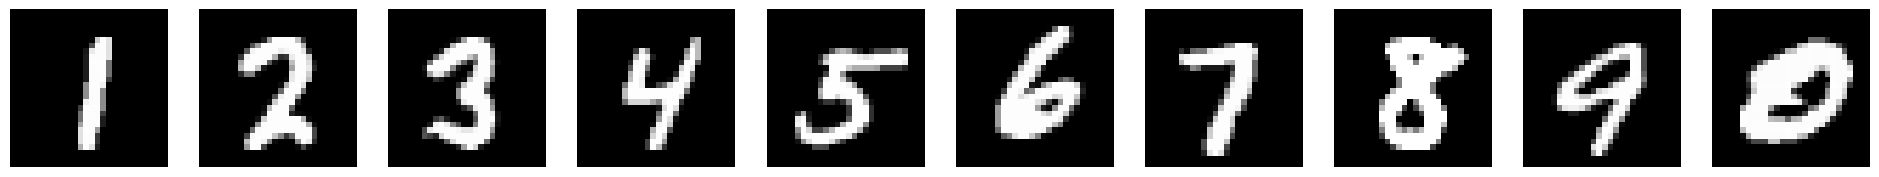

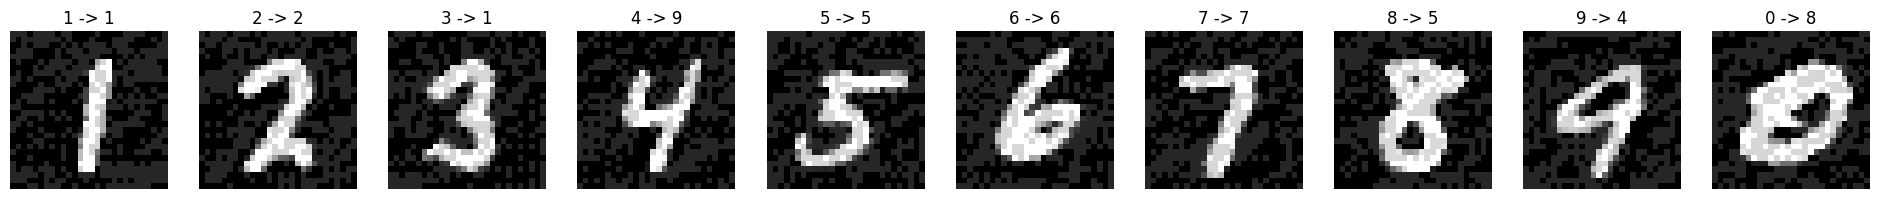

In [2]:
# This cell demonstrates the Fast Gradient Sign Method (FGSM), a simple and fast way to create adversarial examples.
# Adversarial examples are inputs (like images) that are slightly modified to fool a machine learning model, even though the changes are often imperceptible to humans.

# FGSM Attack function
# model: The trained neural network model we want to attack.
# criterion: The loss function used during training (e.g., CrossEntropyLoss).
# images: The original images we want to create adversarial examples from.
# labels: The true labels for the original images.
# step_size: A small value that controls how much noise is added to the image. A larger step size creates a stronger attack but might make the perturbation more visible.
def fgsm(model, criterion, images, labels, step_size) :

    # We need to calculate the gradients of the loss with respect to the input images.
    # Setting requires_grad = True tells PyTorch to keep track of these gradients.
    images.requires_grad = True # give me those gradients!

    # Feed the original images to the model to get the model's initial predictions.
    outputs = model(images)

    # Zero out any previously calculated gradients. This is important before calculating new gradients.
    model.zero_grad() #zero out the gradients
    # Compute the loss value using the model's outputs and the true labels.
    loss = criterion(outputs, labels) # compute loss value
    # Backpropagate the loss to calculate the gradients of the loss with respect to the input images.
    loss.backward() # feedback to the model, compute the gradients.

    # Now, we create the adversarial images.
    # The core idea of FGSM is to add a small perturbation to the original image in the direction that increases the loss the most.
    # This direction is given by the sign of the gradient of the loss with respect to the input image.
    # images.grad.sign(): Gets the sign of each element in the gradient tensor (+1 for positive, -1 for negative, 0 for zero).
    # step_size * images.grad.sign(): Scales the direction by the step size.
    # images + ... : Adds this scaled perturbation to the original images.
    ae_images = images + step_size*images.grad.sign()

    # Clamp the resulting adversarial images to be within the valid pixel range (usually 0 to 1 for normalized images).
    # This ensures the adversarial images are still valid images.
    ae_images = torch.clamp(ae_images, 0, 1)

    # Return the generated adversarial images.
    return ae_images

# Set the model to evaluation mode. This disables features like Dropout and uses learned statistics for BatchNorm, important for consistent evaluation.
model.eval()

# Initialize counters for tracking correct predictions on adversarial examples.
correct = 0
total = 0
# Iterate through each batch of images and labels in the test data loader.
for images, labels in test_loader:
    # Move the images and labels to the GPU if available for faster processing.
    images = images.cuda()
    labels = labels.cuda()
    # Generate adversarial examples using the FGSM function.
    # We use a step_size of 0.15, which is a hyperparameter that can be tuned.
    ae_images = fgsm(model, criterion, images, labels, step_size=0.15)

    # Now, test the trained model (model) on the generated adversarial images (ae_images).
    outputs = model(ae_images)
    # Get the predicted class for each adversarial image.
    # torch.max returns the maximum value and its index. We only need the index (the predicted class).
    _, predicted = torch.max(outputs.data, 1)
    # Update the total count of images processed.
    total += labels.size(0)
    # Update the count of correctly classified adversarial examples.
    # (predicted == labels): checks if the model's prediction on the adversarial image matches the true label.
    # .sum().item(): counts the number of True values (correct predictions).
    correct += (predicted == labels).sum().item()

# Print the accuracy of the model when evaluated on the adversarial examples.
# A significantly lower accuracy compared to the original test accuracy indicates that the model is vulnerable to this attack.
print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

# Display the first 10 original images in the last batch processed.
# .detach(): removes the tensor from the computation graph, so no gradients are tracked.
# .cpu(): moves the tensor to the CPU for Matplotlib.
show_images(images[:10].detach().cpu())
# The line below is commented out, but you could uncomment it to see the adversarial images themselves.
# show_images(ae_images[:10].detach().cpu())
# Display the first 10 adversarial images along with their true labels and the model's predictions on the adversarial images.
show_images_withPred(ae_images[:10].detach().cpu(),labels[:10].cpu(), outputs[:10].argmax(dim=1).cpu())

Accuracy of the model on the 10000 test images: 97.64 %


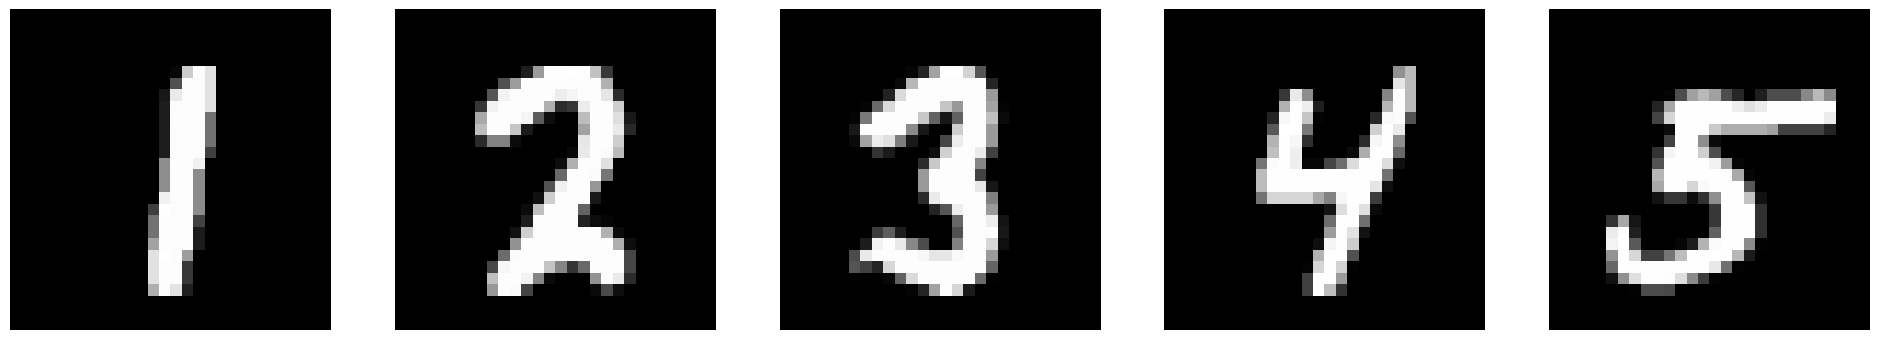

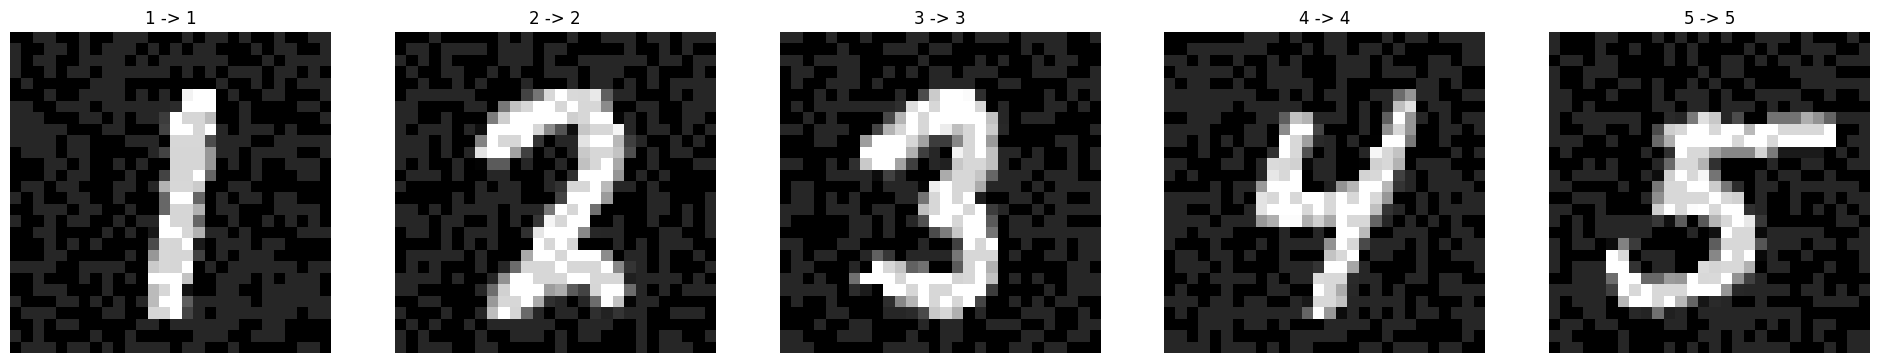

In [3]:
# This cell demonstrates a simple random noise injection attack.
# Unlike FGSM, which uses gradients to find the direction of perturbation that increases loss,
# this method simply adds random noise to the image.

# Random noise injection attack function
# images: The original images to which we want to add random noise.
# step_size: A value that controls the magnitude of the random noise added.
def rand_noise_attack(images, step_size) :
    # Generate random noise with the same shape and data type as the input images.
    rand_perturbation = torch.randn_like(images)
    # Create adversarial images by adding the scaled sign of the random noise to the original images.
    # .sign(): Gets the sign of each element in the random perturbation tensor.
    # step_size * ...: Scales the direction of the noise by the step size.
    # images + ... : Adds this scaled random noise to the original images.
    ae_images = images + step_size*rand_perturbation.sign()
    # The line below is commented out, but you could uncomment it to see the sign of the random perturbation.
    #show_images(rand_perturbation.sign()[:5])
    # Clamp the resulting adversarial images to be within the valid pixel range (usually 0 to 1 for normalized images).
    # This ensures the adversarial images are still valid images.
    ae_images = torch.clamp(ae_images, 0, 1)

    # Return the generated adversarial images.
    return ae_images


# Set the model to evaluation mode.
model.eval()

# Initialize counters for tracking correct predictions on adversarial examples.
correct = 0
total = 0
# Iterate through each batch of images and labels in the test data loader.
for images, labels in test_loader:
    # Move the images and labels to the GPU if available.
    images = images.cuda()
    labels = labels.cuda()
    # Generate adversarial examples by adding random noise using the rand_noise_attack function.
    # We use a step_size of 0.15.
    ae_images = rand_noise_attack(images,step_size=0.15)

    # Test the trained model (model) on the generated adversarial images (ae_images).
    outputs = model(ae_images)
    # Get the predicted class for each adversarial image.
    _, predicted = torch.max(outputs.data, 1)
    # Update the total count of images processed.
    total += labels.size(0)
    # Update the count of correctly classified adversarial examples.
    correct += (predicted == labels).sum().item()

# Print the accuracy of the model when evaluated on the adversarial examples created with random noise.
# Compare this accuracy to the original test accuracy and the FGSM attack accuracy.
print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

# Display the first 5 original images in the last batch processed.
show_images(images[:5].detach())
# Display the first 5 adversarial images created with random noise, along with their true labels and the model's predictions.
show_images_withPred(ae_images[:5].detach(),labels[:5], outputs[:5].argmax(dim=1))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Accuracy of the model on the 10000 test images: 0.09 %


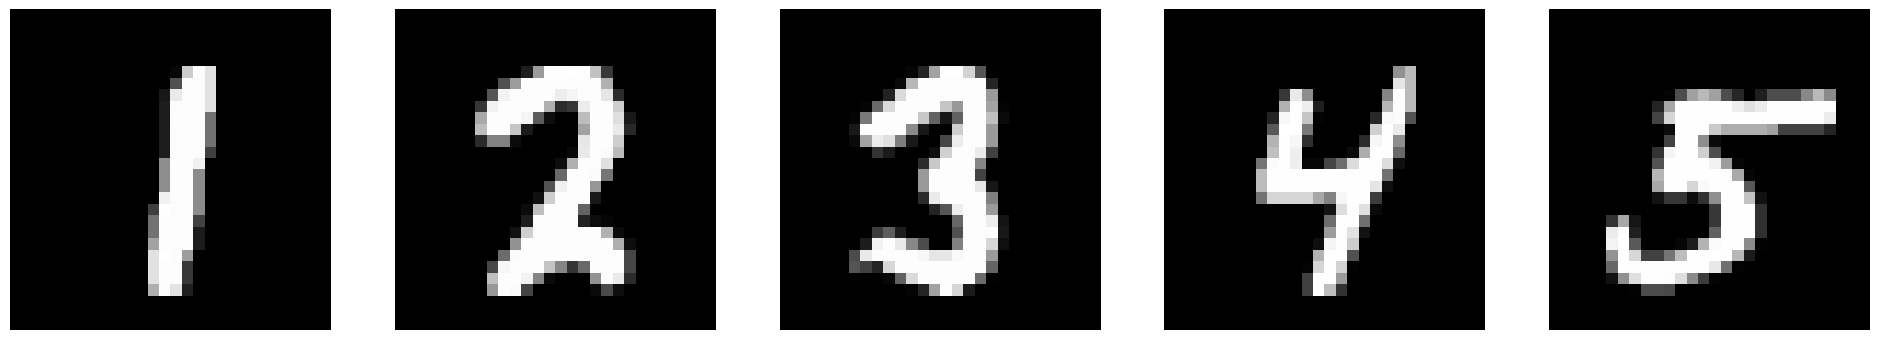

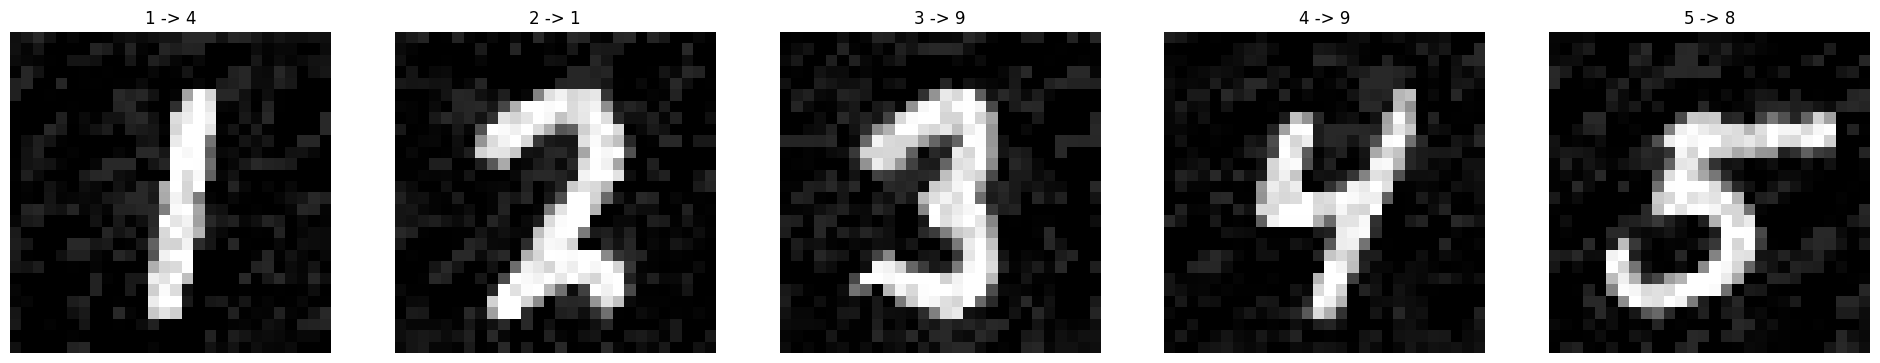

In [ ]:
# This cell demonstrates the Projected Gradient Descent (PGD) adversarial attack.
# PGD is a more powerful attack than FGSM because it performs multiple smaller steps instead of one large step,
# and it projects the perturbed image back into a valid range after each step.

# PGD Attack function
# model: The trained neural network model to attack.
# images: The original images to generate adversarial examples from.
# criterion: The loss function.
# labels: The true labels for the original images.
# eps: The maximum allowed perturbation (how much the adversarial image can differ from the original). This is often called the epsilon budget.
# step_size: The size of each small step taken during the iterative process.
# iters: The number of steps (iterations) to perform. More iterations generally lead to a stronger attack but take longer.
def pgd_attack(model, images, criterion, labels, eps=0.3, step_size=0.004, iters=40) :
    # Move images and labels to the GPU for faster computation.
    images = images.cuda()
    labels = labels.cuda()

    # Store the original images to ensure the final adversarial image is within a certain distance from the original.
    ori_images = images.data

    # Start the iterative process for PGD.
    for i in range(iters) :
        # We need to calculate gradients with respect to the image, so we require gradients.
        images.requires_grad = True
        # Feed the current version of the image (either original or a perturbed version from a previous step) to the model.
        outputs = model(images)

        # Zero out any previously calculated gradients.
        model.zero_grad()
        # Compute the loss between the model's output and the true labels.
        cost = criterion(outputs, labels)
        # Backpropagate the loss to calculate gradients of the loss with respect to the image.
        cost.backward()

        # Generate a potential adversarial image by adding the scaled sign of the gradient.
        # This is similar to the FGSM step, taking a step in the direction that increases the loss.
        adv_images = images + step_size*images.grad.sign()
        # Calculate the difference between the potential adversarial image and the original image.
        eta = adv_images - ori_images
        # Clamp the perturbation (eta) to be within the epsilon budget. This ensures the perturbation is not too large.
        # min=-eps, max=eps: Ensures that the perturbation for each pixel is between -eps and +eps.
        eta = torch.clamp(eta, min=-eps, max=eps)
        # Update the image by adding the clamped perturbation to the original image.
        # Clamp the resulting image back to the valid pixel range [0, 1].
        # .detach_(): Detaches the tensor from the computation graph in-place. This is important to stop tracking gradients for the next iteration's input.
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()

    # Return the final adversarial images after all iterations.
    return images


# Set the model to evaluation mode.
model.eval()

# Initialize counters for tracking correct predictions on adversarial examples generated by PGD.
correct = 0
total = 0
# Iterate through each batch of images and labels in the test data loader.
for images, labels in test_loader:
    # Move the images and labels to the GPU.
    images = images.cuda()
    labels = labels.cuda()
    # Generate adversarial examples using the PGD attack function.
    # We use default values for eps, step_size, and iters, but these can be tuned.
    ae_images = pgd_attack(model, images, criterion,labels)

    # Test the trained model on the generated PGD adversarial images.
    outputs = model(ae_images)
    # Get the predicted class for each adversarial image.
    _, predicted = torch.max(outputs.data, 1)
    # Update the total count of images processed.
    total += labels.size(0)
    # Update the count of correctly classified adversarial examples.
    correct += (predicted == labels).sum().item()

# Print the accuracy of the model when evaluated on the PGD adversarial examples.
# PGD is often a strong attack, so the accuracy here is likely to be very low.
print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

# Display the first 5 original images in the last batch processed.
# .detach(): Removes the tensor from the computation graph for plotting.
show_images(images[:5].detach())
# Display the first 5 PGD adversarial images along with their true labels and the model's predictions on these images.
show_images_withPred(ae_images[:5].detach(),labels[:5], outputs[:5].argmax(dim=1))

In [ ]:
# This cell demonstrates how an attacker might train a "substitute model" (Model B) in a black-box attack scenario.
# In a true black-box attack, the attacker doesn't know the exact architecture of the target model (Model A),
# but here, for demonstration purposes, we assume the attacker has a guess about a similar architecture.
# The goal is to train a model (Model B) on a limited dataset (simulating the attacker's resources)
# and then use this model to generate adversarial examples that can fool the original target model (Model A).

# Model B, ideal case, the attacker has the knowledge of the model A's architecture.
# This class defines the architecture of the attacker's substitute model (Model B).
# It's a simple CNN, similar to the target model (Model A) we trained earlier.
class Attacker_Model(nn.Module):
    def __init__(self):
        super(Attacker_Model, self).__init__()
        # Define the layers for extracting features from the images, similar to Model A.
        self.features = nn.Sequential(
            # Convolutional layer 1: Takes a grayscale image (1 input channel) and outputs 6 feature maps.
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2), # Max pooling to reduce spatial dimensions.
            # Convolutional layer 2: Takes 6 input channels and outputs 16 feature maps.
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2), # Max pooling.
            nn.Flatten(1, -1), # Flatten the output for the fully connected layers.
        )
        # Define the fully connected layers for classification.
        self.fc1 = nn.Linear(7 * 7 * 16, 120) # First fully connected layer.
        self.fc2 = nn.Linear(120, 84) # Second fully connected layer.
        self.fc3 = nn.Linear(84, 10) # Output layer, mapping to 10 classes (digits 0-9).

    # Define the forward pass for Model B.
    def forward(self, x):
        out = self.features(x) # Pass input through feature layers.
        out = self.fc1(out) # Pass through first fully connected layer.
        out = self.fc2(out) # Pass through second fully connected layer.
        out = self.fc3(out) # Pass through output layer to get predictions.

        return out

# Create an instance of the attacker's model (Model B).
model_B=Attacker_Model()
# Move Model B to the GPU for faster training.
model_B.cuda()
# Set Model B to training mode.
model_B.train()


# Assume the attacker has a smaller dataset (5000 images) compared to the target model's training data.
# This simulates a more realistic black-box scenario where the attacker doesn't have the full original dataset.
from torch.utils.data import Subset

# Create a list of indices from 0 to 4999 to select a subset of the training dataset.
tempid = torch.range(0, 5000,dtype=torch.int)
# Create a Subset of the original training dataset using the selected indices.
train_dataset_attacker = Subset(train_dataset, tempid)
# Data loader for the attacker's training dataset.
# This will load the 5000 images in batches for training Model B.
train_loader_attacker = DataLoader(dataset=train_dataset_attacker, batch_size=batch_size, num_workers=4, shuffle=True)

# Define the Loss function and optimizer for training Model B.
criterion = nn.CrossEntropyLoss() # Cross-entropy loss, same as used for Model A.
optimizer_attacker = torch.optim.Adam(model_B.parameters(), lr=learning_rate) # Adam optimizer for Model B.


# Train model B
model_B.train() # Set Model B to training mode.
loss_list_cnn = [] # List to store loss values during training of Model B.
acc_list_cnn = [] # List to store accuracy values during training of Model B.
total_step = len(train_loader_attacker) # Total number of steps (batches) in one epoch for Model B's training.

# Start the training loop for Model B.
for epoch in range(40): # Train for 40 epochs (this number can be tuned).
  # Iterate through each batch in the attacker's training data loader.
  for i, (images, labels) in enumerate(train_loader_attacker):
    # Move images and labels to the GPU.
    images = images.cuda()
    labels = labels.cuda()

    # Forward pass: Get predictions from Model B.
    outputs = model_B(images)

    # Compute the loss for Model B.
    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item()) # Store the loss.

    # Backprop and perform Adam optimisation
    optimizer_attacker.zero_grad() # Zero the gradients for Model B.
    loss.backward() # Backpropagation for Model B.
    optimizer_attacker.step() # Update Model B's parameters.

    # Track the accuracy for Model B during training.
    total = labels.size(0) # Total samples in the current batch.
    _, predicted = torch.max(outputs.data, 1) # Get Model B's predicted class.
    correct = (predicted == labels).sum().item() # Count correct predictions.
    acc_list_cnn.append(correct / total) # Store the accuracy.

    # Print training progress for Model B.
    if (i%150 == 0): # Print every 150 steps (although the attacker's dataset is small, so this might not print often).
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, 40, i, total_step, loss.item(),
                      (correct / total) * 100))


# Evaluate Model B on the *full* test dataset to see how well it performs.
# This is not part of the *attack* itself, but helps assess how similar Model B is to a well-trained model.
model_B.eval() # Set Model B to evaluation mode.
with torch.no_grad(): # Disable gradient calculation.
  correct = 0
  total = 0
  # Iterate through the full test dataset.
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model_B(images) # Get predictions from Model B on test images.
      _, predicted = torch.max(outputs.data, 1) # Get Model B's predicted class.
      total += labels.size(0) # Update total count.
      correct += (predicted == labels).sum().item() # Update correct count.

# Print the final accuracy of Model B on the test set.
# A higher accuracy here suggests that Model B has learned to classify digits well, which is important for generating transferable adversarial examples.
print(
  'Accuracy of the model_B on the 10000 test images: {} %'.format((correct / total) * 100))

/tmp/ipython-input-3412542810.py:50: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  tempid = torch.range(0, 5000,dtype=torch.int)


Epoch [1/10], Step [0/20], Loss: 2.2998, Accuracy: 9.38%
Epoch [2/10], Step [0/20], Loss: 1.0530, Accuracy: 68.75%
Epoch [3/10], Step [0/20], Loss: 0.5253, Accuracy: 84.38%
Epoch [4/10], Step [0/20], Loss: 0.3096, Accuracy: 89.84%
Epoch [5/10], Step [0/20], Loss: 0.2470, Accuracy: 92.58%
Epoch [6/10], Step [0/20], Loss: 0.2818, Accuracy: 90.62%
Epoch [7/10], Step [0/20], Loss: 0.2163, Accuracy: 91.80%
Epoch [8/10], Step [0/20], Loss: 0.2108, Accuracy: 95.31%
Epoch [9/10], Step [0/20], Loss: 0.1423, Accuracy: 96.88%
Epoch [10/10], Step [0/20], Loss: 0.1354, Accuracy: 97.27%
Epoch [11/10], Step [0/20], Loss: 0.1004, Accuracy: 97.27%
Epoch [12/10], Step [0/20], Loss: 0.0810, Accuracy: 97.66%
Epoch [13/10], Step [0/20], Loss: 0.1205, Accuracy: 96.48%
Epoch [14/10], Step [0/20], Loss: 0.0753, Accuracy: 97.66%
Epoch [15/10], Step [0/20], Loss: 0.0553, Accuracy: 98.44%
Epoch [16/10], Step [0/20], Loss: 0.0639, Accuracy: 98.05%
Epoch [17/10], Step [0/20], Loss: 0.0411, Accuracy: 99.61%
Epoch [

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Accuracy of the model_B on the 10000 test images: 23.25 %
Accuracy of the model on the 10000 test images: 83.36 %


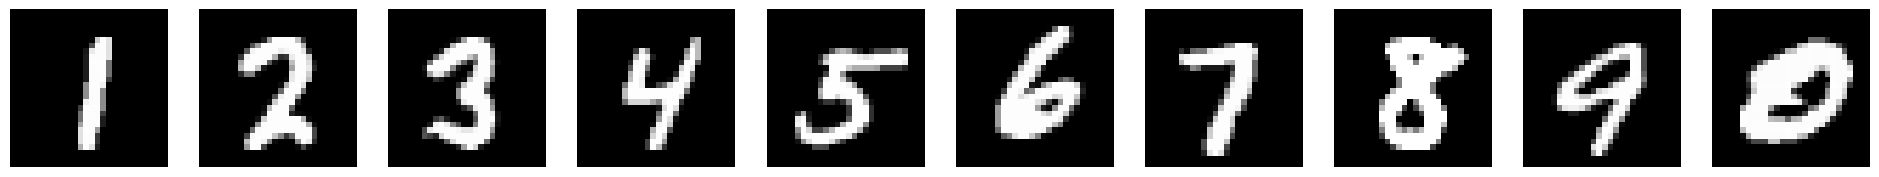

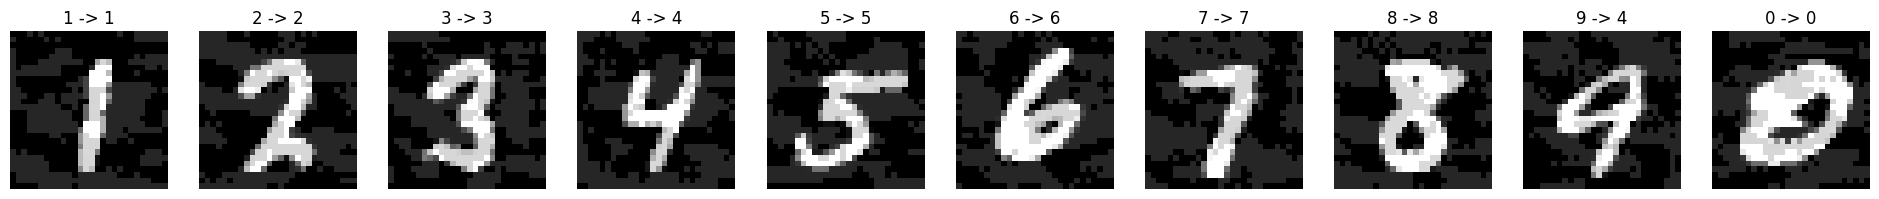

In [ ]:
# This cell demonstrates the black-box attack scenario where adversarial examples (AEs) are generated on a substitute model (model_B)
# and then tested on the original target model (model).
# The idea is to see if the AEs generated on the attacker's model can "transfer" and fool the victim model.

# Set both models to evaluation mode. This is important for consistent evaluation and disables training-specific features.
model.eval() # Set the original target model (Model A) to evaluation mode.
model_B.eval() # Set the attacker's substitute model (Model B) to evaluation mode.

# Initialize counters for tracking correct predictions for both models when evaluated on the adversarial examples.
correct = 0 # Counts how many adversarial images the original model (Model A) classifies correctly.
total = 0 # Counts the total number of adversarial images evaluated on Model A.

correct_B = 0 # Counts how many adversarial images the substitute model (Model B) classifies correctly.
total_B = 0 # Counts the total number of adversarial images evaluated on Model B.

# Iterate through each batch of images and labels in the test data loader.
# We use the test data to generate AEs and evaluate both models.
for images, labels in test_loader:
    # Move the images and labels to the GPU for faster processing.
    images = images.cuda()
    labels = labels.cuda()
    # Generate AEs on model B using the FGSM attack function.
    # We use the attacker's model (model_B) and the test images to create adversarial examples.
    # The FGSM function calculates the perturbation based on the gradients of model_B.
    ae_images = fgsm(model_B, criterion, images, labels, step_size=0.15)

    # Compute local accuracy on model B.
    # This shows how well the AEs generated on Model B fool Model B itself. This should be low if the attack is successful on Model B.
    outputs_B = model_B(ae_images) # Get predictions from Model B on the adversarial images.
    _, predicted_B = torch.max(outputs_B.data, 1) # Get the predicted class for Model B.
    total_B += labels.size(0) # Update the total count for Model B evaluation.
    correct_B += (predicted_B == labels).sum().item() # Count correct predictions for Model B.

    # Compute accuracy on model A (the target model).
    # This is the crucial part: how well do the AEs generated on Model B fool Model A?
    # A lower accuracy here compared to Model A's original test accuracy indicates a successful black-box attack via transferability.
    outputs = model(ae_images) # Get predictions from the original target model (Model A) on the same adversarial images generated on Model B.
    _, predicted = torch.max(outputs.data, 1) # Get the predicted class for Model A.
    total += labels.size(0) # Update the total count for Model A evaluation.
    correct += (predicted == labels).sum().item() # Count correct predictions for Model A.

# Print the accuracy of the substitute model (Model B) on the adversarial examples it generated.
# This is the "white-box" attack success rate on Model B.
print(
  'Accuracy of the model_B on the 10000 test images: {} %'.format((correct_B / total_B) * 100))

# Print the accuracy of the original target model (Model A) on the adversarial examples generated on Model B.
# This is the "black-box" attack success rate on Model A due to transferability.
# Compare this value to the original accuracy of Model A (printed in the first code cell) to see if the attack was successful.
print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

# Display the first 10 original images from the last batch processed.
# .detach(): creates a new tensor that doesn't track gradients, needed for plotting.
show_images(images[:10].detach().cpu())
# Display the first 10 adversarial images generated on Model B, along with their true labels and Model A's predictions on them.
# ae_images[:10].detach().cpu(): Selects the first 10 adversarial images, detaches them, and moves to CPU.
# labels[:10].cpu(): Selects the true labels and moves to CPU.
# outputs[:10].argmax(dim=1).cpu(): Gets Model A's predicted class for the first 10 AEs and moves to CPU.
show_images_withPred(ae_images[:10].detach().cpu(),labels[:10].cpu(), outputs[:10].argmax(dim=1).cpu())

In [4]:
epsilon_values = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

In [5]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Clean accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Clean accuracy of the model on the 10000 test images: 98.74000000000001 %


In [6]:
fgsm_accuracies = []

for epsilon in epsilon_values:
    model.eval()
    correct_fgsm = 0
    total_fgsm = 0
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()
        ae_images = fgsm(model, criterion, images, labels, step_size=epsilon)

        outputs = model(ae_images)
        _, predicted = torch.max(outputs.data, 1)
        total_fgsm += labels.size(0)
        correct_fgsm += (predicted == labels).sum().item()

    accuracy = (correct_fgsm / total_fgsm) * 100
    fgsm_accuracies.append(accuracy)
    print(f'FGSM accuracy for epsilon={epsilon}: {accuracy:.2f}%')


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM accuracy for epsilon=0.0: 98.74%
FGSM accuracy for epsilon=0.05: 77.33%
FGSM accuracy for epsilon=0.1: 48.43%
FGSM accuracy for epsilon=0.15: 32.88%
FGSM accuracy for epsilon=0.2: 23.06%
FGSM accuracy for epsilon=0.25: 17.38%
FGSM accuracy for epsilon=0.3: 14.44%


Visualizing examples for epsilon = 0.1


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


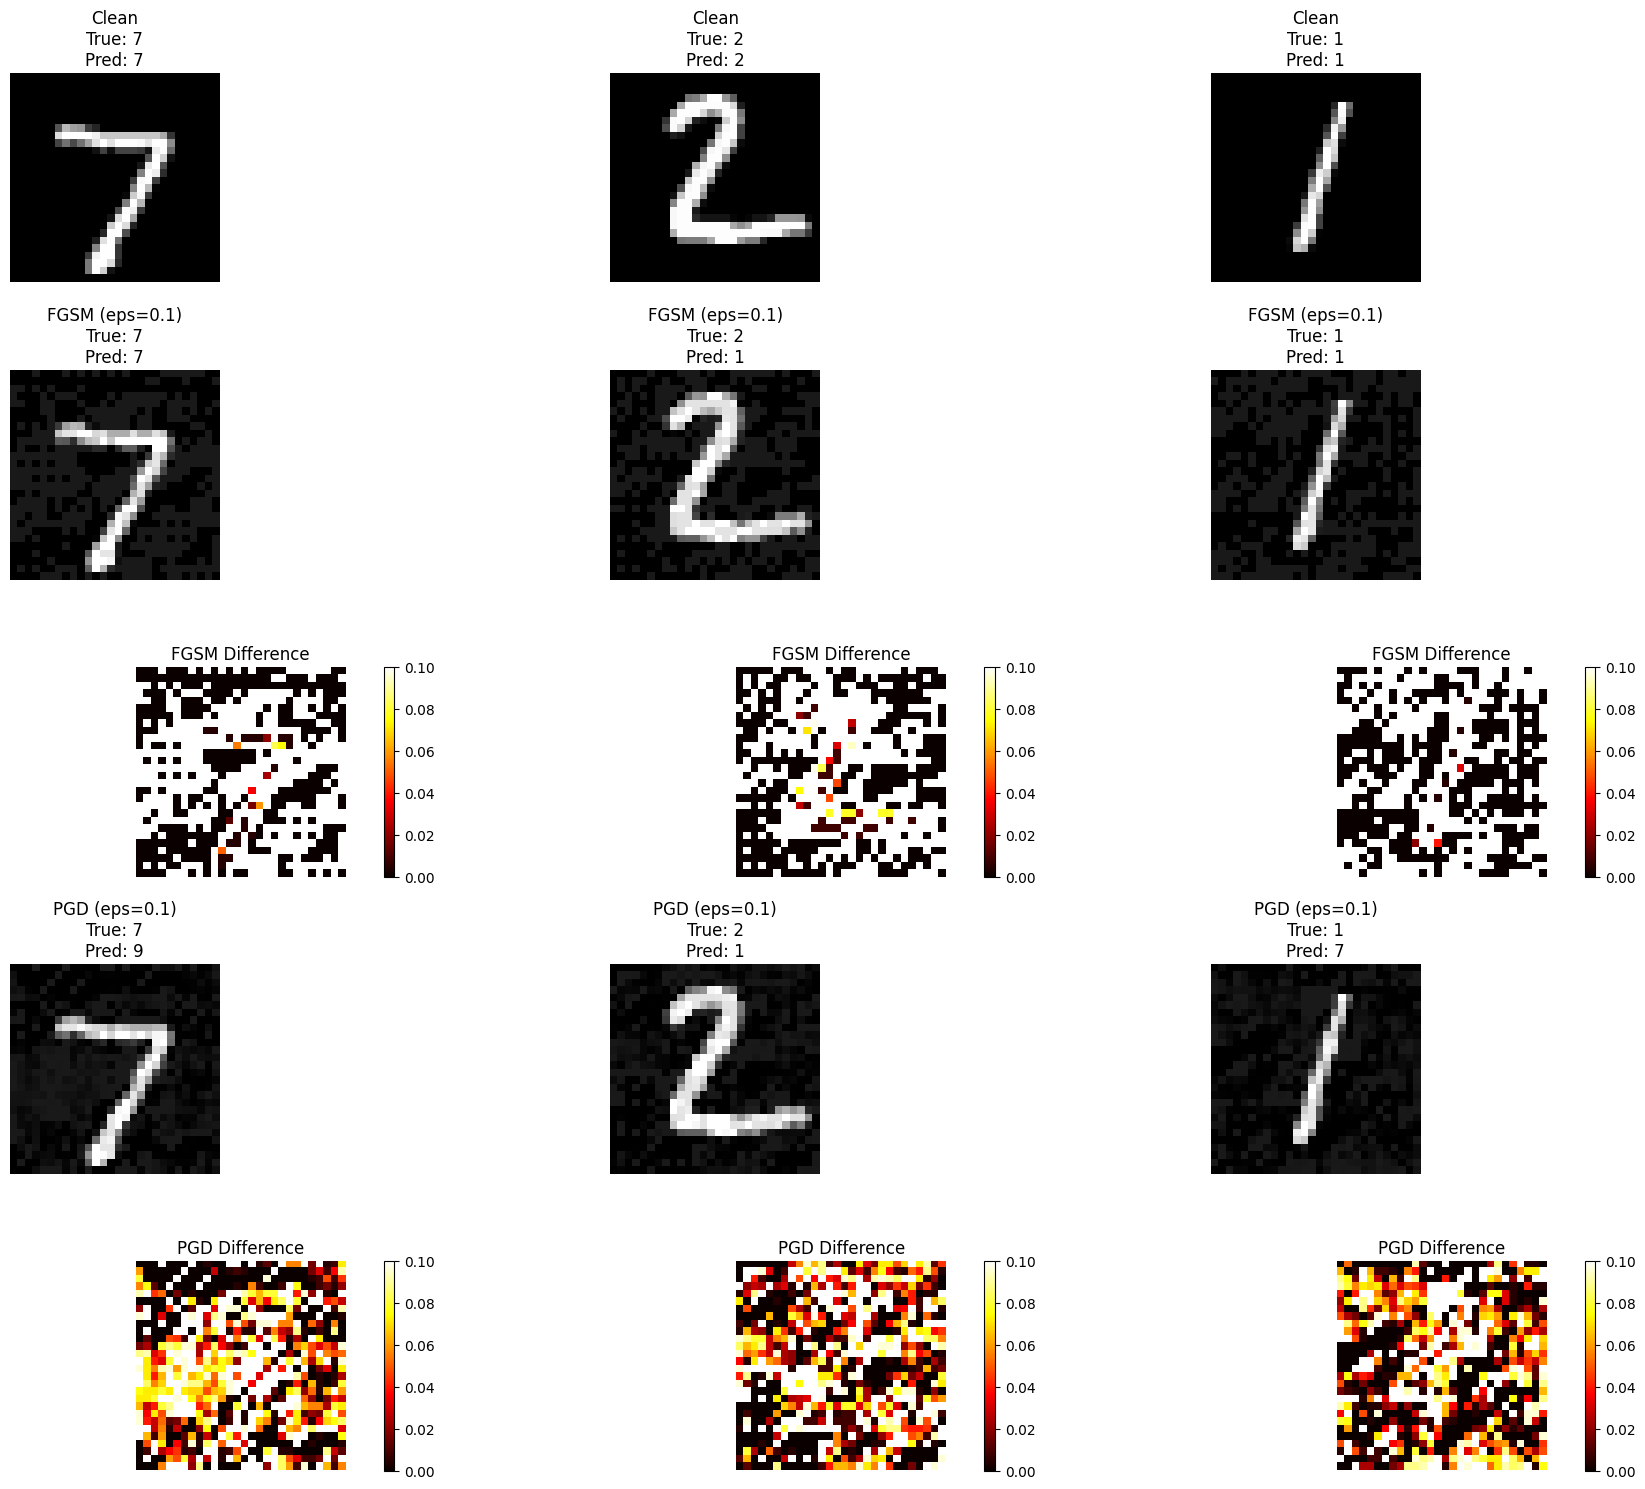

Visualizing examples for epsilon = 0.3


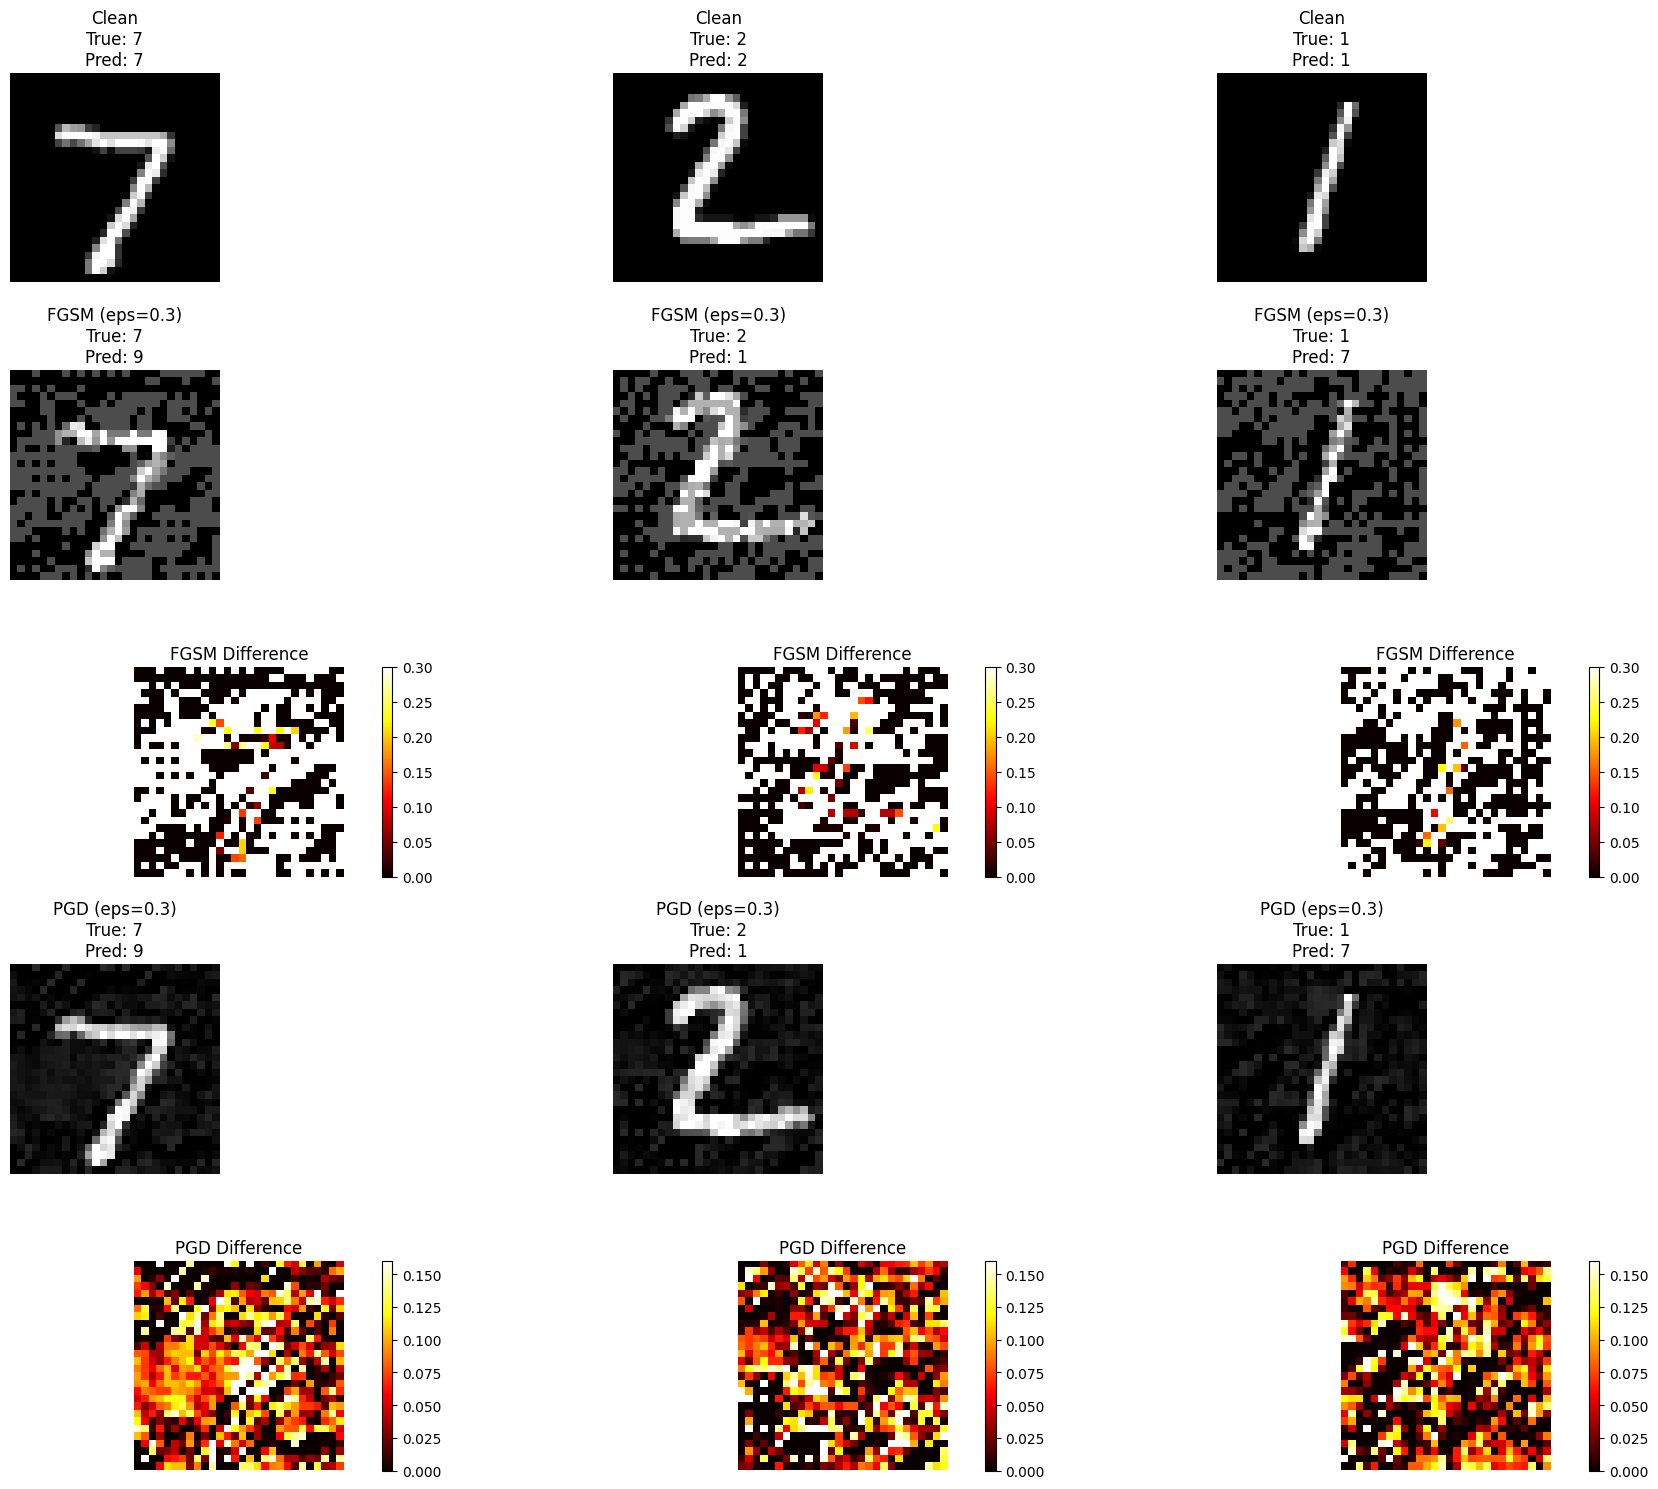

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a few representative epsilon values for visualization
visualization_epsilons = [0.1, 0.3]

# We will only visualize a few examples per epsilon
num_examples_to_show = 3

model.eval()

for epsilon in visualization_epsilons:
    print(f"Visualizing examples for epsilon = {epsilon}")
    # Get a single batch for visualization
    for batch_idx, (images, labels) in enumerate(test_loader):
        if batch_idx >= 1: # Process only the first batch
            break

        images = images.cuda()
        labels = labels.cuda()

        # Get clean predictions
        outputs_clean = model(images)
        _, predicted_clean = torch.max(outputs_clean.data, 1)

        # Generate FGSM adversarial images
        ae_fgsm = fgsm(model, criterion, images, labels, step_size=epsilon)
        outputs_fgsm = model(ae_fgsm)
        _, predicted_fgsm = torch.max(outputs_fgsm.data, 1)

        # Generate PGD adversarial images
        with torch.enable_grad():
             ae_pgd = pgd_attack(model, images, criterion, labels, eps=epsilon, iters=40, step_size=0.004)

        # Evaluate the model on PGD adversarial examples
        outputs_pgd = model(ae_pgd)
        _, predicted_pgd = torch.max(outputs_pgd.data, 1)

        # Display comparison
        plt.figure(figsize=(20, 15))
        for i in range(min(images.size(0), num_examples_to_show)):
            # Clean Image (Row 1)
            plt.subplot(5, num_examples_to_show, i + 1)
            plt.imshow(images[i].detach().cpu().squeeze(), cmap='gray')
            plt.title(f"Clean\nTrue: {labels[i].item()}\nPred: {predicted_clean[i].item()}")
            plt.axis('off')

            # FGSM Adversarial Image (Row 2)
            plt.subplot(5, num_examples_to_show, i + 1 + num_examples_to_show)
            plt.imshow(ae_fgsm[i].detach().cpu().squeeze(), cmap='gray')
            plt.title(f"FGSM (eps={epsilon})\nTrue: {labels[i].item()}\nPred: {predicted_fgsm[i].item()}")
            plt.axis('off')

            # FGSM Difference Heatmap (Row 3)
            diff_fgsm = torch.abs(images[i].detach() - ae_fgsm[i].detach()).mean(dim=0)
            plt.subplot(5, num_examples_to_show, i + 1 + 2 * num_examples_to_show)
            plt.imshow(diff_fgsm.cpu().squeeze(), cmap='hot', interpolation='nearest')
            plt.title("FGSM Difference")
            plt.colorbar()
            plt.axis('off')

            # PGD Adversarial Image (Row 4)
            plt.subplot(5, num_examples_to_show, i + 1 + 3 * num_examples_to_show)
            plt.imshow(ae_pgd[i].detach().cpu().squeeze(), cmap='gray')
            plt.title(f"PGD (eps={epsilon})\nTrue: {labels[i].item()}\nPred: {predicted_pgd[i].item()}")
            plt.axis('off')

            # PGD Difference Heatmap (Row 5)
            diff_pgd = torch.abs(images[i].detach() - ae_pgd[i].detach()).mean(dim=0)
            plt.subplot(5, num_examples_to_show, i + 1 + 4 * num_examples_to_show)
            plt.imshow(diff_pgd.cpu().squeeze(), cmap='hot', interpolation='nearest')
            plt.title("PGD Difference")
            plt.colorbar()
            plt.axis('off')

        plt.tight_layout()
        plt.show()

--- Model Accuracy on Clean vs. Adversarial Data ---


,Epsilon,FGSM Accuracy (%),PGD Accuracy (%)
0,0.00,98.74,98.74
1,0.05,77.33,40.67
2,0.10,48.43,1.13
3,0.15,32.88,0.36
4,0.20,23.06,0.34
5,0.25,17.38,0.34
6,0.30,14.44,0.34


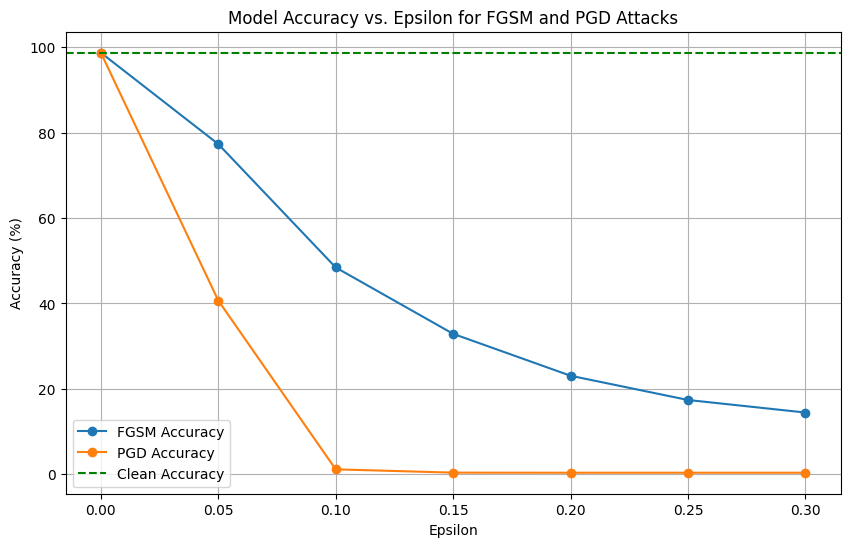

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame to display the accuracy data
data = {'Epsilon': epsilon_values,
        'FGSM Accuracy (%)': fgsm_accuracies,
        'PGD Accuracy (%)': pgd_accuracies}
accuracy_df = pd.DataFrame(data)

# Add a row for clean accuracy (epsilon=0.0)
clean_accuracy_row = pd.DataFrame({'Epsilon': [0.0],
                                    'FGSM Accuracy (%)': [clean_accuracy],
                                    'PGD Accuracy (%)': [clean_accuracy]})

# Concatenate clean accuracy row with the rest of the data
accuracy_df = pd.concat([clean_accuracy_row, accuracy_df[accuracy_df['Epsilon'] > 0.0]], ignore_index=True)

print("--- Model Accuracy on Clean vs. Adversarial Data ---")
display(accuracy_df)

# Plot the accuracy vs. epsilon value
plt.figure(figsize=(10, 6))
plt.plot(accuracy_df['Epsilon'], accuracy_df['FGSM Accuracy (%)'], marker='o', label='FGSM Accuracy')
plt.plot(accuracy_df['Epsilon'], accuracy_df['PGD Accuracy (%)'], marker='o', label='PGD Accuracy')
plt.axhline(y=clean_accuracy, color='g', linestyle='--', label='Clean Accuracy')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy vs. Epsilon for FGSM and PGD Attacks')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# This cell is no longer needed as the PGD accuracy calculation is now included in the cell where the pgd_attack function is defined.
# The code below has been moved to cell nPS1x4E8eytj.

# pgd_accuracies = []

# for epsilon in epsilon_values:
#     model.eval()
#     correct_pgd = 0
#     total_pgd = 0
#     with torch.no_grad():
#         for images, labels in test_loader:
#             images = images.cuda()
#             labels = labels.cuda()
#             # Generate adversarial examples using PGD attack
#             ae_images = pgd_attack(model, images, criterion, labels, eps=epsilon, iters=40, step_size=0.004)

#             # Evaluate the model on adversarial examples
#             outputs = model(ae_images)
#             _, predicted = torch.max(outputs.data, 1)
#             total_pgd += labels.size(0)
#             correct_pgd += (predicted == labels).sum().item()

#     accuracy = (correct_pgd / total_pgd) * 100
#     pgd_accuracies.append(accuracy)
#     print(f'PGD accuracy for epsilon={epsilon}: {accuracy:.2f}%')

In [23]:
# This cell demonstrates the Projected Gradient Descent (PGD) adversarial attack.
# PGD is a more powerful attack than FGSM because it performs multiple smaller steps instead of one large step,
# and it projects the perturbed image back into a valid range after each step.

# PGD Attack function
# model: The trained neural network model to attack.
# images: The original images to generate adversarial examples from.
# criterion: The loss function.
# labels: The true labels for the original images.
# eps: The maximum allowed perturbation (how much the adversarial image can differ from the original). This is often called the epsilon budget.
# step_size: The size of each small step taken during the iterative process.
# iters: The number of steps (iterations) to perform. More iterations generally lead to a stronger attack but take longer.
def pgd_attack(model, images, criterion, labels, eps=0.3, step_size=0.004, iters=40) :
    # Move images and labels to the GPU for faster computation.
    images = images.cuda()
    labels = labels.cuda()

    # Store the original images to ensure the final adversarial image is within a certain distance from the original.
    ori_images = images.data

    # Start the iterative process for PGD.
    for i in range(iters) :
        # We need to calculate gradients with respect to the image, so we require gradients.
        images.requires_grad = True
        # Feed the current version of the image (either original or a perturbed version from a previous step) to the model.
        outputs = model(images)

        # Zero out any previously calculated gradients.
        model.zero_grad()
        # Compute the loss between the model's output and the true labels.
        cost = criterion(outputs, labels)
        # Backpropagate the loss to calculate gradients of the loss with respect to the image.
        cost.backward()

        # Generate a potential adversarial image by adding the scaled sign of the gradient.
        # This is similar to the FGSM step, taking a step in the direction that increases the loss.
        adv_images = images + step_size*images.grad.sign()
        # Calculate the difference between the potential adversarial image and the original image.
        eta = adv_images - ori_images
        # Clamp the perturbation (eta) to be within the epsilon budget. This ensures the perturbation is not too large.
        # min=-eps, max=eps: Ensures that the perturbation for each pixel is between -eps and +eps.
        eta = torch.clamp(eta, min=-eps, max=eps)
        # Update the image by adding the clamped perturbation to the original image.
        # Clamp the resulting image back to the valid pixel range [0, 1].
        # .detach_(): Detaches the tensor from the computation graph in-place. This is important to stop tracking gradients for the next iteration's input.
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()

    # Return the final adversarial images after all iterations.
    return images

pgd_accuracies = []

for epsilon in epsilon_values:
    model.eval()
    correct_pgd = 0
    total_pgd = 0
    with torch.no_grad(): # It is important to keep torch.no_grad() outside the inner loop for PGD
        for images, labels in test_loader:
            images = images.cuda()
            labels = labels.cuda()
            # Generate adversarial examples using PGD attack
            # Temporarily enable gradients for the attack function
            with torch.enable_grad():
                ae_images = pgd_attack(model, images, criterion, labels, eps=epsilon, iters=40, step_size=0.004)

            # Evaluate the model on adversarial examples
            outputs = model(ae_images)
            _, predicted = torch.max(outputs.data, 1)
            total_pgd += labels.size(0)
            correct_pgd += (predicted == labels).sum().item()

    accuracy = (correct_pgd / total_pgd) * 100
    pgd_accuracies.append(accuracy)
    print(f'PGD accuracy for epsilon={epsilon}: {accuracy:.2f}%')

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


PGD accuracy for epsilon=0.0: 98.74%
PGD accuracy for epsilon=0.05: 40.67%
PGD accuracy for epsilon=0.1: 1.13%
PGD accuracy for epsilon=0.15: 0.36%
PGD accuracy for epsilon=0.2: 0.34%
PGD accuracy for epsilon=0.25: 0.34%
PGD accuracy for epsilon=0.3: 0.34%


In [9]:
print("--- Adversarial Attack Accuracy Report ---")
# Clean accuracy was calculated in a previous step and stored in the 'correct' and 'total' variables
clean_accuracy = (correct / total) * 100
print(f"Clean Accuracy: {clean_accuracy:.2f}%")
print("\nAccuracy vs. Epsilon Value:")

for i, epsilon in enumerate(epsilon_values):
    print(f"Epsilon = {epsilon}:")
    print(f"  FGSM Accuracy: {fgsm_accuracies[i]:.2f}%")
    print(f"  PGD Accuracy:  {pgd_accuracies[i]:.2f}%")

--- Adversarial Attack Accuracy Report ---
Clean Accuracy: 98.74%

Accuracy vs. Epsilon Value:
Epsilon = 0.0:
  FGSM Accuracy: 98.74%
  PGD Accuracy:  98.74%
Epsilon = 0.05:
  FGSM Accuracy: 77.33%
  PGD Accuracy:  40.67%
Epsilon = 0.1:
  FGSM Accuracy: 48.43%
  PGD Accuracy:  1.13%
Epsilon = 0.15:
  FGSM Accuracy: 32.88%
  PGD Accuracy:  0.36%
Epsilon = 0.2:
  FGSM Accuracy: 23.06%
  PGD Accuracy:  0.34%
Epsilon = 0.25:
  FGSM Accuracy: 17.38%
  PGD Accuracy:  0.34%
Epsilon = 0.3:
  FGSM Accuracy: 14.44%
  PGD Accuracy:  0.34%


Visualizing examples for epsilon = 0.1


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


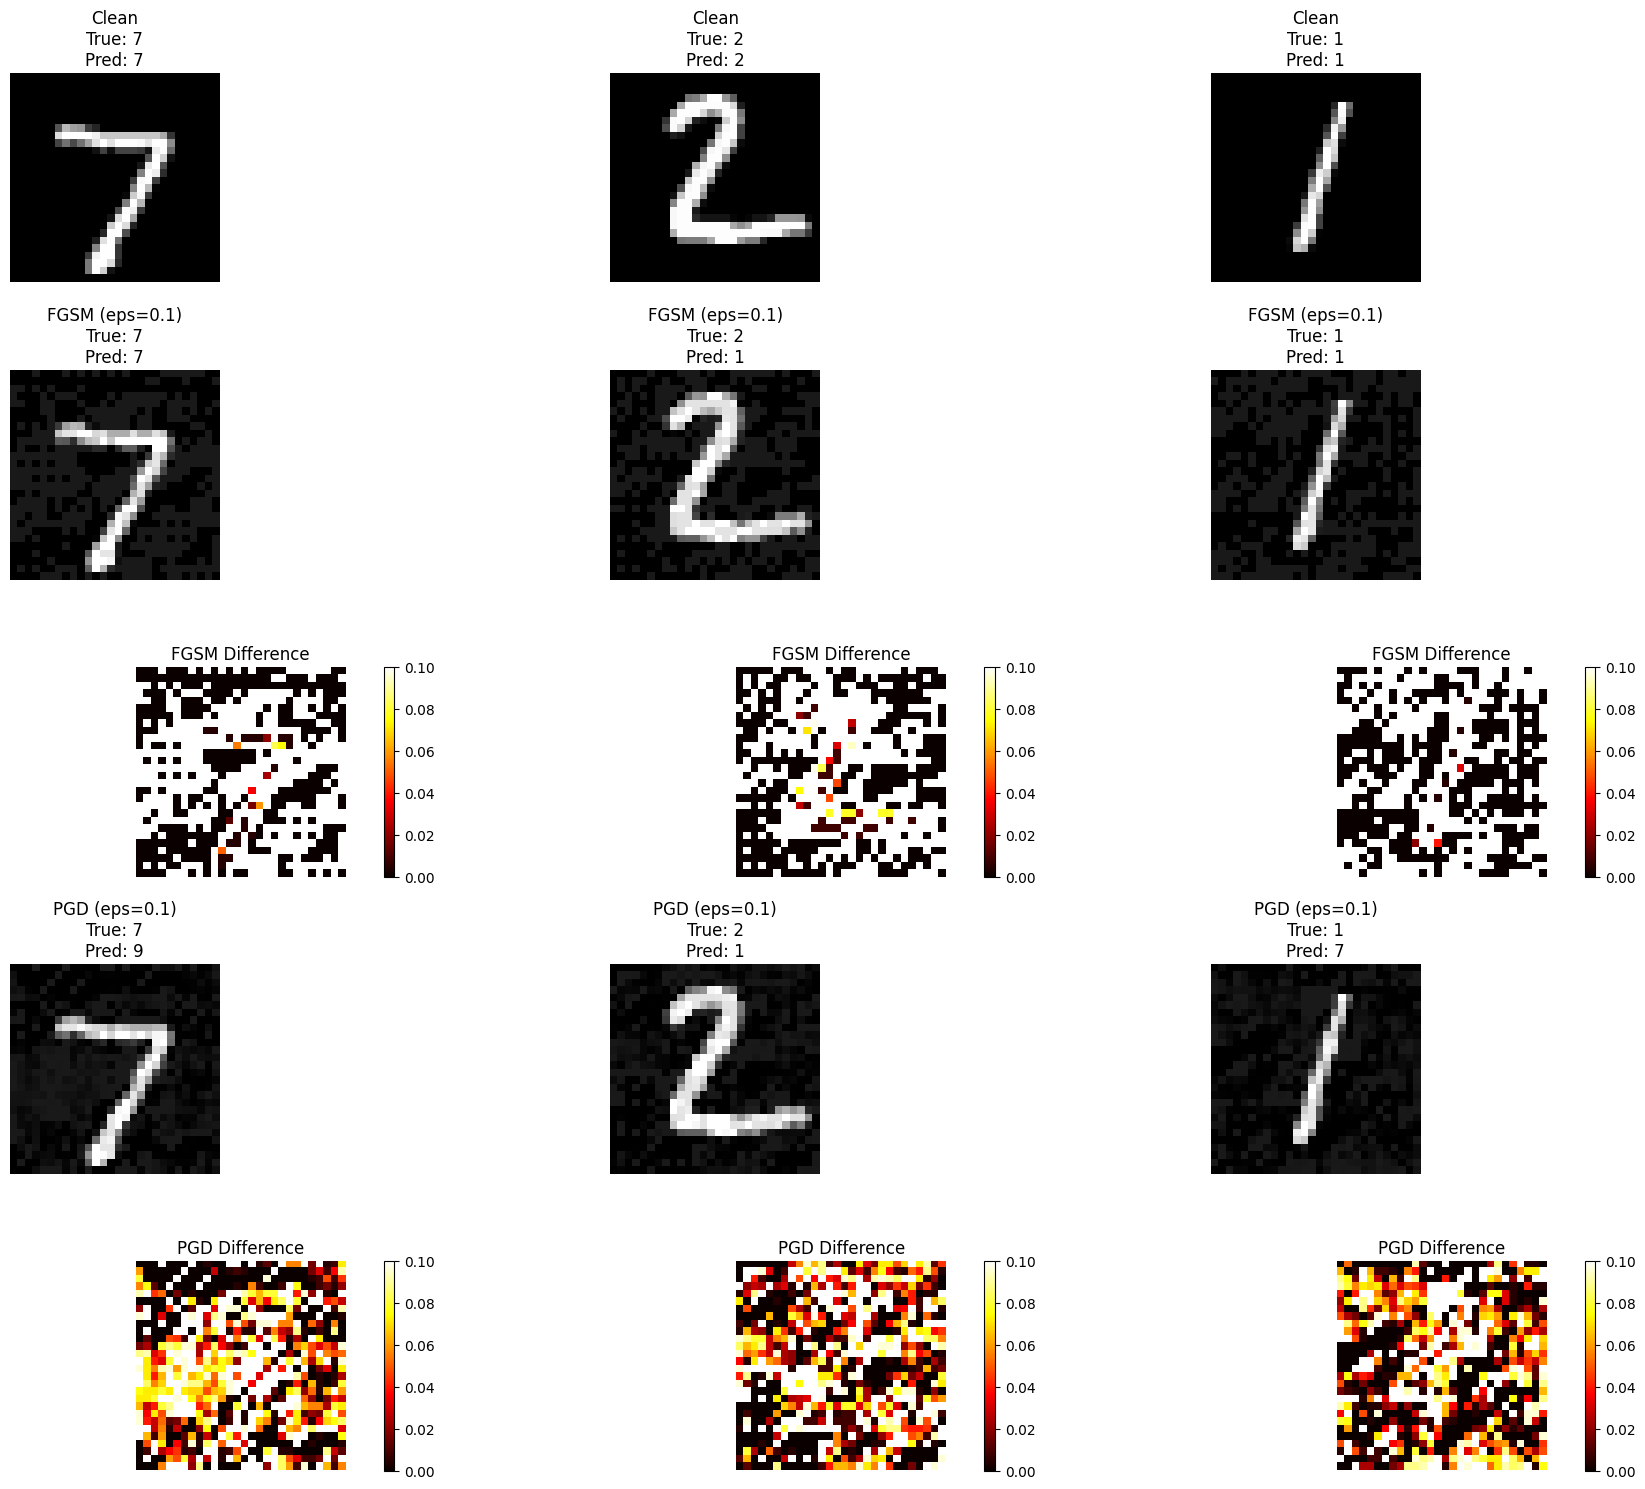

Visualizing examples for epsilon = 0.3


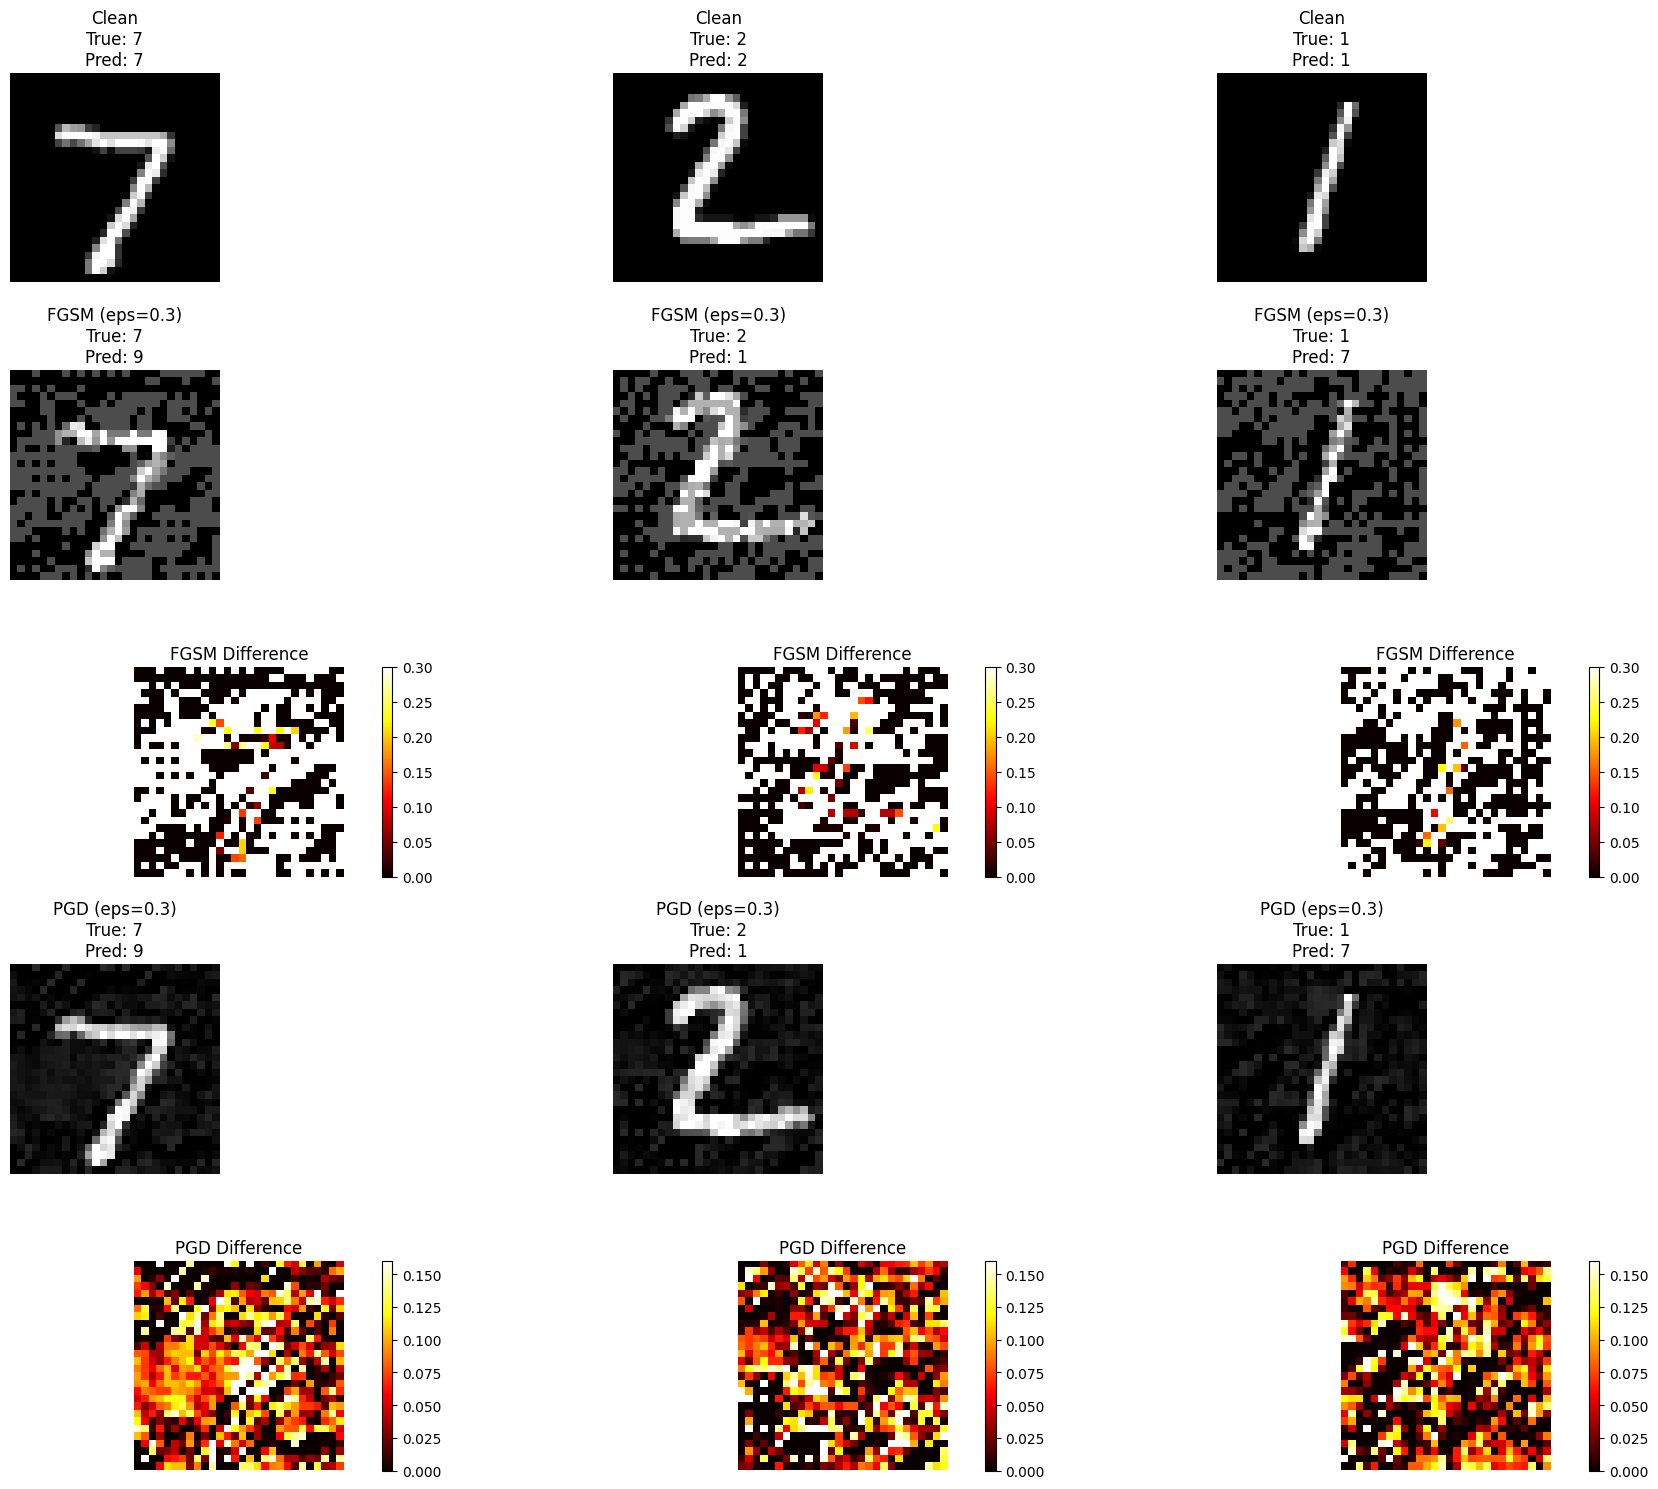

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a few representative epsilon values for visualization
# Using epsilon values that showed varying attack effectiveness
visualization_epsilons = [0.1, 0.3]

# Iterate through a small subset of the test_loader (e.g., the first batch)
# We will only visualize a few examples per epsilon
num_examples_to_show = 3

# Helper function to display images and heatmaps
def show_adversarial_comparison(clean_images, ae_fgsm, ae_pgd, true_labels, pred_clean, pred_fgsm, pred_pgd, epsilon):
    n = clean_images.size(0)
    # Adjust figure size and layout for 5 rows (clean, FGSM AE, FGSM heatmap, PGD AE, PGD heatmap)
    plt.figure(figsize=(20, 15))

    for i in range(min(n, num_examples_to_show)):
        # Clean Image (Row 1)
        plt.subplot(5, num_examples_to_show, i + 1)
        plt.imshow(clean_images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"Clean\nTrue: {true_labels[i].item()}\nPred: {pred_clean[i].item()}")
        plt.axis('off')

        # FGSM Adversarial Image (Row 2)
        plt.subplot(5, num_examples_to_show, i + 1 + num_examples_to_show)
        plt.imshow(ae_fgsm[i].cpu().squeeze(), cmap='gray')
        plt.title(f"FGSM (eps={epsilon})\nTrue: {true_labels[i].item()}\nPred: {pred_fgsm[i].item()}")
        plt.axis('off')

        # FGSM Difference Heatmap (Row 3)
        diff_fgsm = torch.abs(clean_images[i] - ae_fgsm[i]).mean(dim=0)
        plt.subplot(5, num_examples_to_show, i + 1 + 2 * num_examples_to_show)
        plt.imshow(diff_fgsm.cpu().squeeze(), cmap='hot', interpolation='nearest')
        plt.title("FGSM Difference")
        plt.colorbar()
        plt.axis('off')

        # PGD Adversarial Image (Row 4)
        plt.subplot(5, num_examples_to_show, i + 1 + 3 * num_examples_to_show)
        plt.imshow(ae_pgd[i].cpu().squeeze(), cmap='gray')
        plt.title(f"PGD (eps={epsilon})\nTrue: {true_labels[i].item()}\nPred: {pred_pgd[i].item()}")
        plt.axis('off')

        # PGD Difference Heatmap (Row 5)
        diff_pgd = torch.abs(clean_images[i] - ae_pgd[i]).mean(dim=0)
        plt.subplot(5, num_examples_to_show, i + 1 + 4 * num_examples_to_show)
        plt.imshow(diff_pgd.cpu().squeeze(), cmap='hot', interpolation='nearest')
        plt.title("PGD Difference")
        plt.colorbar()
        plt.axis('off')


    plt.tight_layout()
    plt.show()


model.eval()

for epsilon in visualization_epsilons:
    print(f"Visualizing examples for epsilon = {epsilon}")
    # Get a single batch for visualization
    for i, (images, labels) in enumerate(test_loader):
        if i >= 1: # Process only the first batch
            break

        images = images.cuda()
        labels = labels.cuda()

        # Get clean predictions
        outputs_clean = model(images)
        _, predicted_clean = torch.max(outputs_clean.data, 1)

        # Generate FGSM adversarial images
        ae_fgsm = fgsm(model, criterion, images, labels, step_size=epsilon)
        outputs_fgsm = model(ae_fgsm)
        _, predicted_fgsm = torch.max(outputs_fgsm.data, 1)


        # Generate PGD adversarial images
        # Need to enable gradients temporarily for PGD attack
        with torch.enable_grad():
            ae_pgd = pgd_attack(model, images, criterion, labels, eps=epsilon, iters=40, step_size=0.004)

        # Evaluate the model on PGD adversarial examples
        outputs_pgd = model(ae_pgd)
        _, predicted_pgd = torch.max(outputs_pgd.data, 1)


        # Display comparison
        show_adversarial_comparison(images.detach(), ae_fgsm.detach(), ae_pgd.detach(), labels.detach(), predicted_clean.detach(), predicted_fgsm.detach(), predicted_pgd.detach(), epsilon)

Visualizing examples for epsilon = 0.1


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


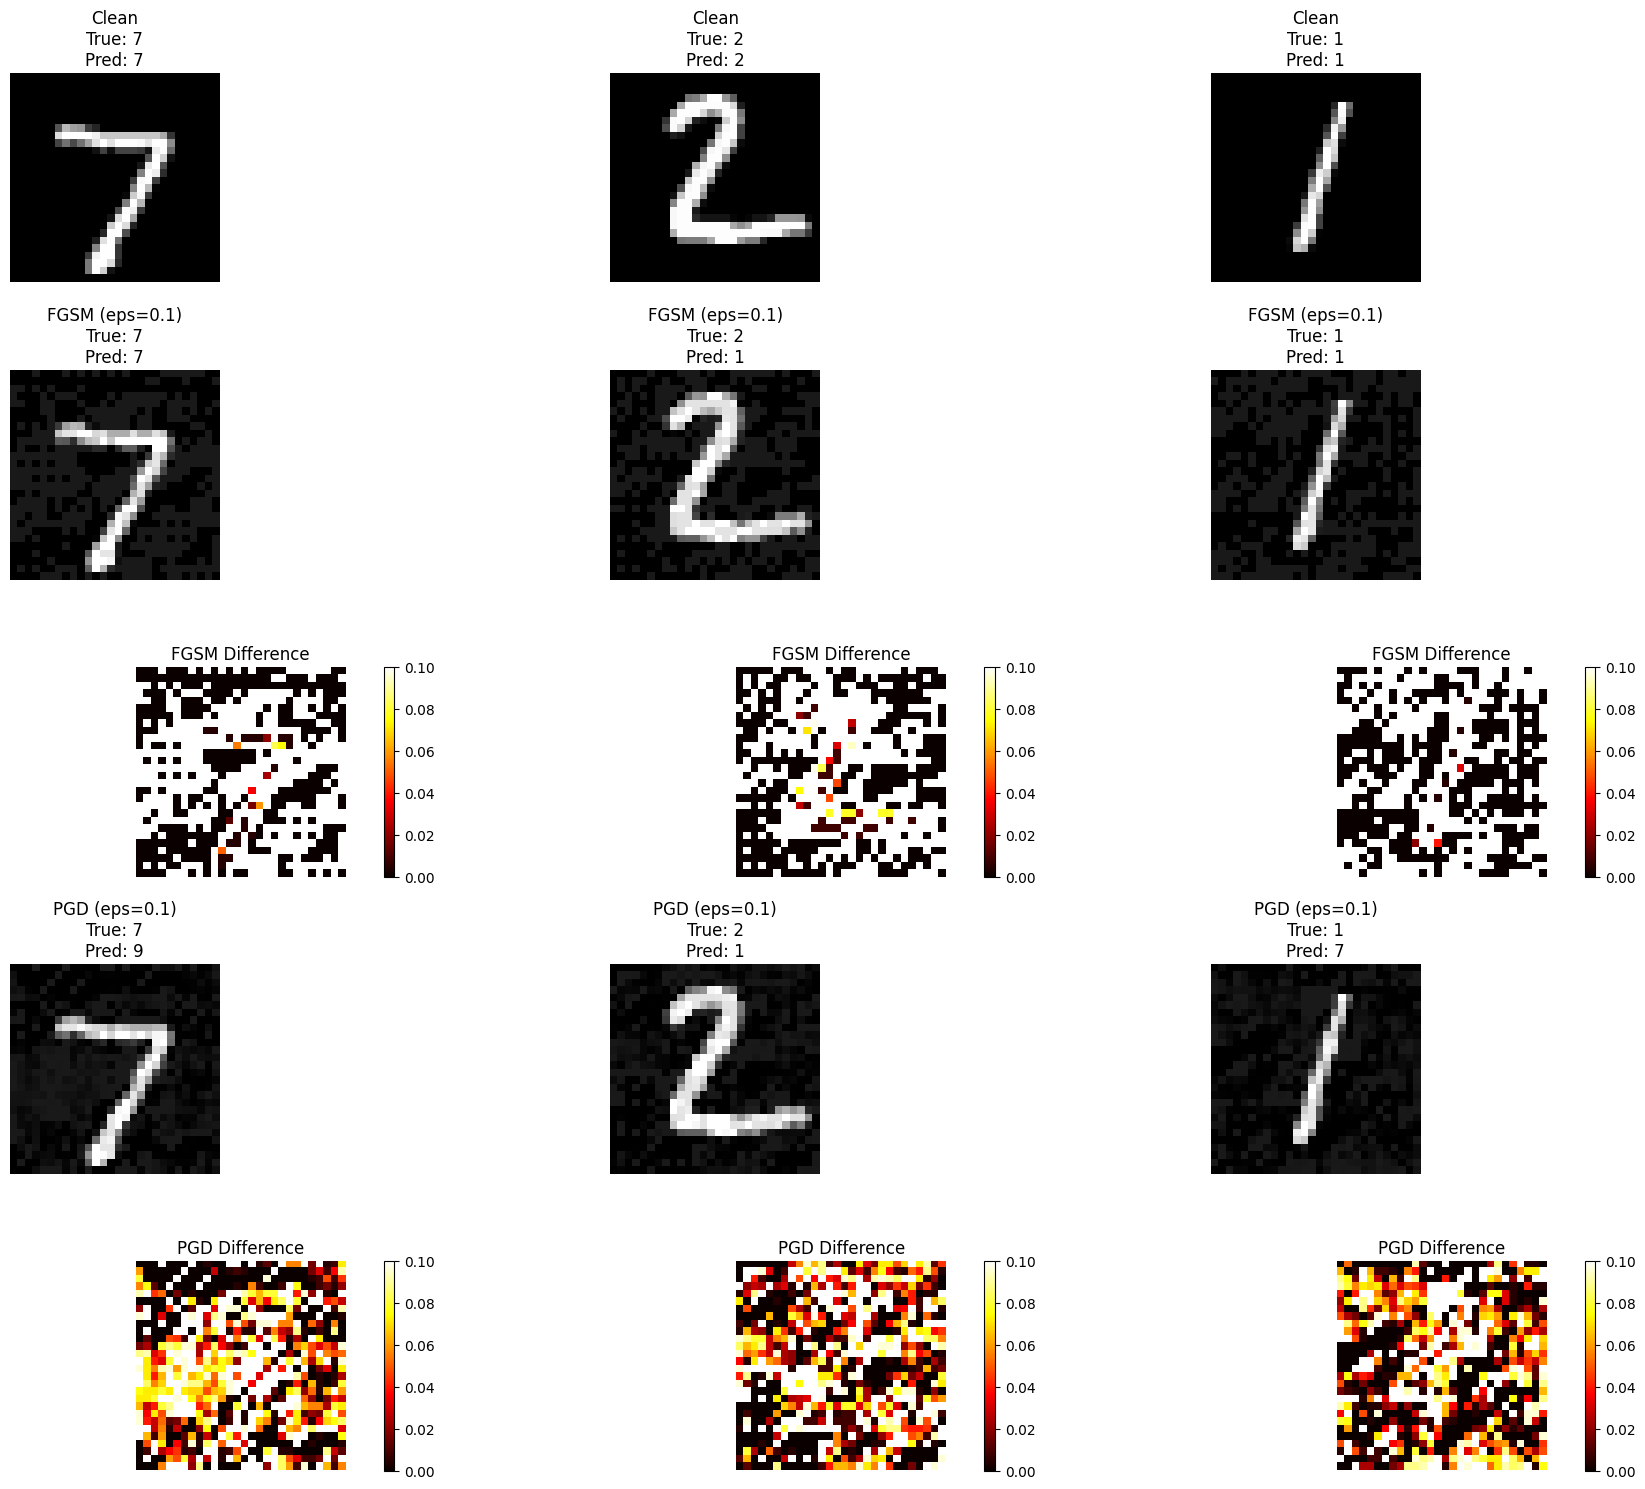

Visualizing examples for epsilon = 0.3


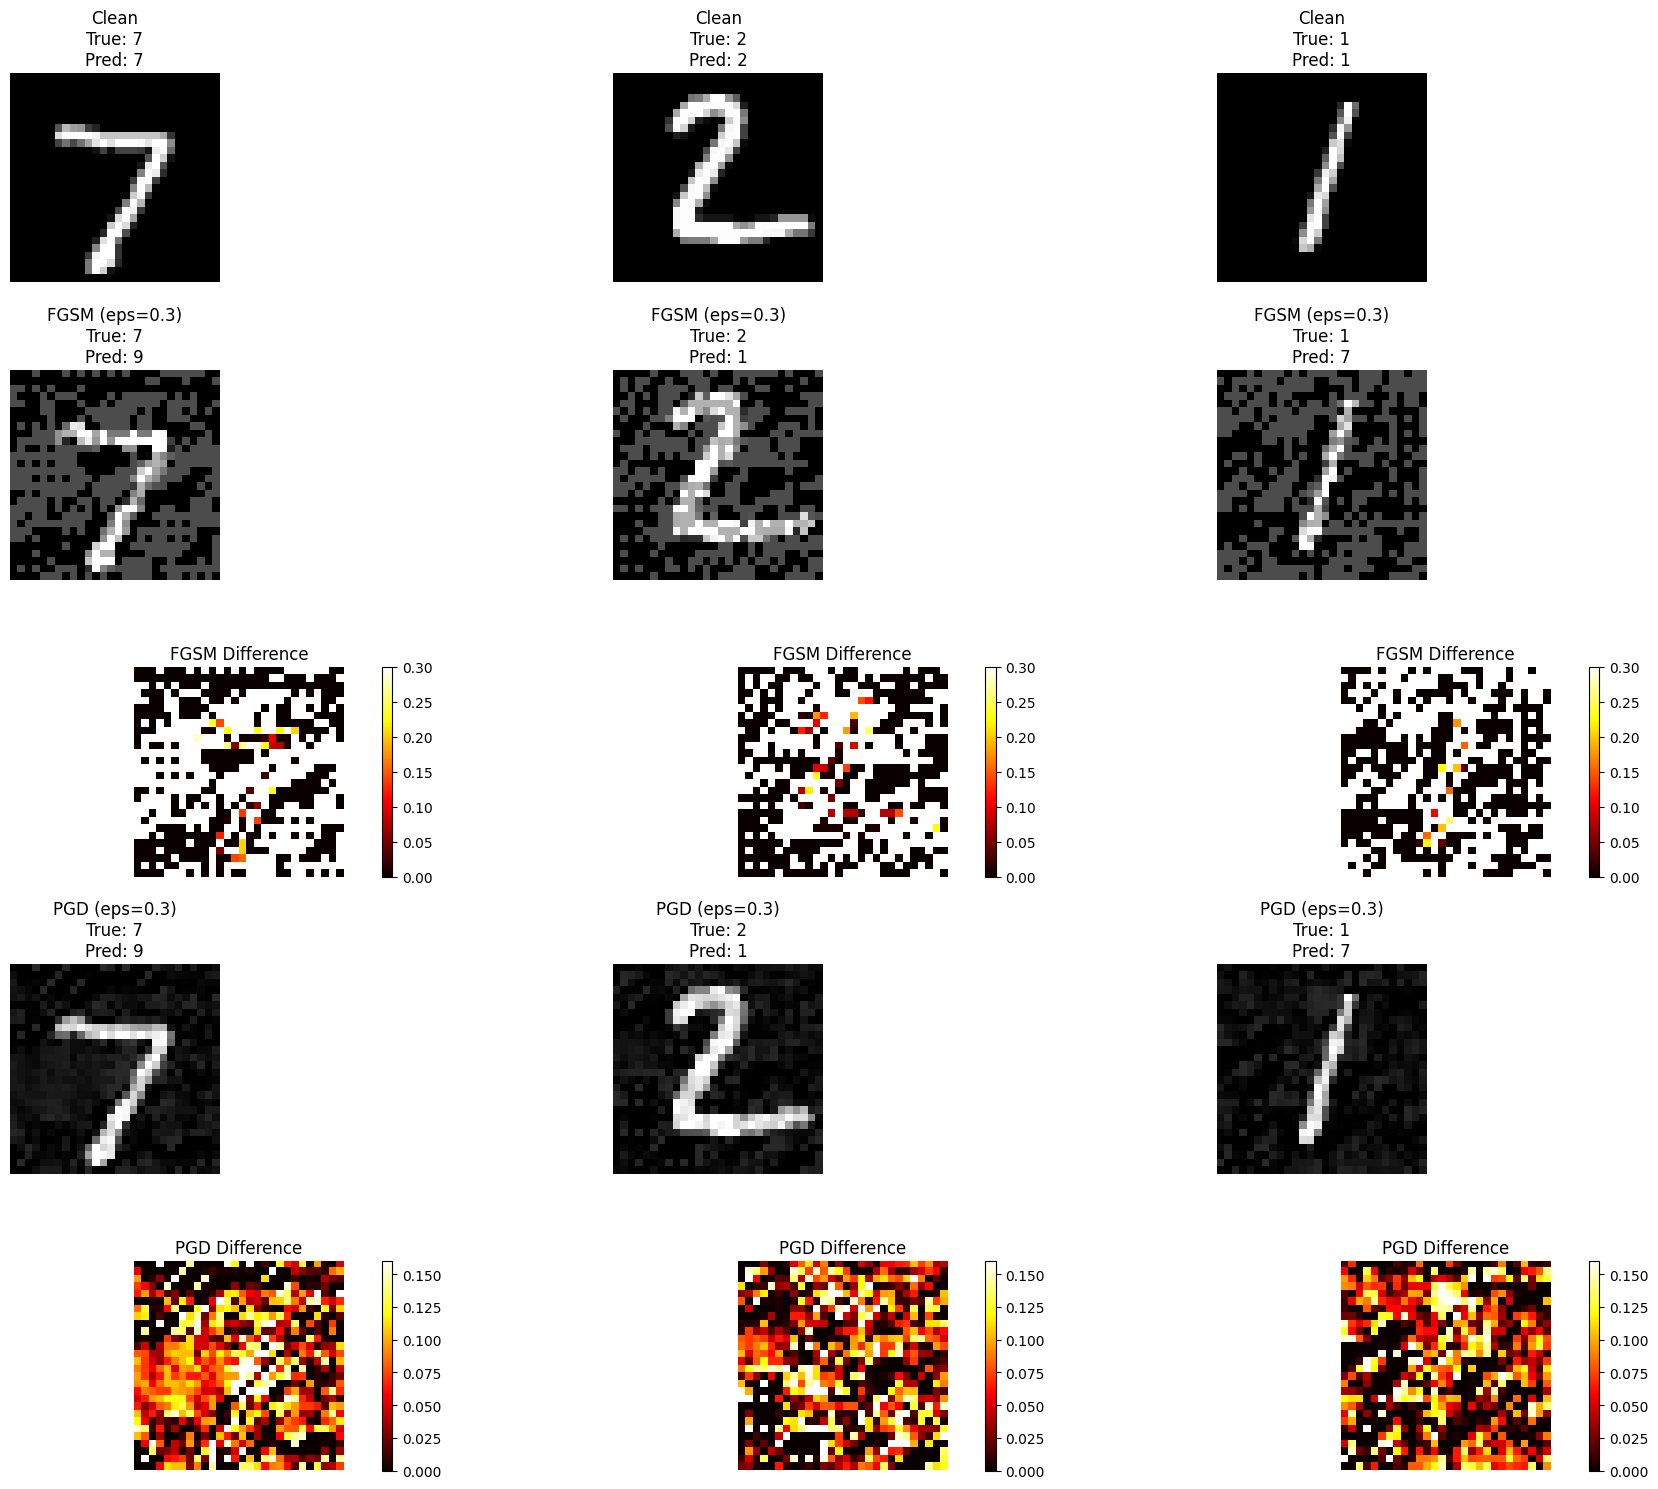

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a few representative epsilon values for visualization
# Using epsilon values that showed varying attack effectiveness
visualization_epsilons = [0.1, 0.3]

# Iterate through a small subset of the test_loader (e.g., the first batch)
# We will only visualize a few examples per epsilon
num_examples_to_show = 3

# Helper function to display images and heatmaps
def show_adversarial_comparison(clean_images, ae_fgsm, ae_pgd, true_labels, pred_clean, pred_fgsm, pred_pgd, epsilon):
    n = clean_images.size(0)
    # Adjust figure size and layout for 5 rows (clean, FGSM AE, FGSM heatmap, PGD AE, PGD heatmap)
    plt.figure(figsize=(20, 15))

    for i in range(min(n, num_examples_to_show)):
        # Clean Image
        plt.subplot(5, num_examples_to_show, i + 1)
        plt.imshow(clean_images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"Clean\nTrue: {true_labels[i].item()}\nPred: {pred_clean[i].item()}")
        plt.axis('off')

        # FGSM Adversarial Image
        plt.subplot(5, num_examples_to_show, i + 1 + num_examples_to_show)
        plt.imshow(ae_fgsm[i].cpu().squeeze(), cmap='gray')
        plt.title(f"FGSM (eps={epsilon})\nTrue: {true_labels[i].item()}\nPred: {pred_fgsm[i].item()}")
        plt.axis('off')

        # FGSM Difference Heatmap
        diff_fgsm = torch.abs(clean_images[i] - ae_fgsm[i]).mean(dim=0)
        plt.subplot(5, num_examples_to_show, i + 1 + 2 * num_examples_to_show)
        plt.imshow(diff_fgsm.cpu().squeeze(), cmap='hot', interpolation='nearest')
        plt.title("FGSM Difference")
        plt.colorbar()
        plt.axis('off')

        # PGD Adversarial Image
        plt.subplot(5, num_examples_to_show, i + 1 + 3 * num_examples_to_show)
        plt.imshow(ae_pgd[i].cpu().squeeze(), cmap='gray')
        plt.title(f"PGD (eps={epsilon})\nTrue: {true_labels[i].item()}\nPred: {pred_pgd[i].item()}")
        plt.axis('off')

        # PGD Difference Heatmap
        diff_pgd = torch.abs(clean_images[i] - ae_pgd[i]).mean(dim=0)
        plt.subplot(5, num_examples_to_show, i + 1 + 4 * num_examples_to_show)
        plt.imshow(diff_pgd.cpu().squeeze(), cmap='hot', interpolation='nearest')
        plt.title("PGD Difference")
        plt.colorbar()
        plt.axis('off')


    plt.tight_layout()
    plt.show()


model.eval()

for epsilon in visualization_epsilons:
    print(f"Visualizing examples for epsilon = {epsilon}")
    # Get a single batch for visualization
    for i, (images, labels) in enumerate(test_loader):
        if i >= 1: # Process only the first batch
            break

        images = images.cuda()
        labels = labels.cuda()

        # Get clean predictions
        outputs_clean = model(images)
        _, predicted_clean = torch.max(outputs_clean.data, 1)

        # Generate FGSM adversarial images
        ae_fgsm = fgsm(model, criterion, images, labels, step_size=epsilon)
        outputs_fgsm = model(ae_fgsm)
        _, predicted_fgsm = torch.max(outputs_fgsm.data, 1)


        # Generate PGD adversarial images
        # Need to enable gradients temporarily for PGD attack
        with torch.enable_grad():
            ae_pgd = pgd_attack(model, images, criterion, labels, eps=epsilon, iters=40, step_size=0.004)

        # Evaluate the model on PGD adversarial examples
        outputs_pgd = model(ae_pgd)
        _, predicted_pgd = torch.max(outputs_pgd.data, 1)


        # Display comparison
        show_adversarial_comparison(images.detach(), ae_fgsm.detach(), ae_pgd.detach(), labels.detach(), predicted_clean.detach(), predicted_fgsm.detach(), predicted_pgd.detach(), epsilon)

In [12]:
print("--- Accuracy Comparison (FGSM vs. PGD) ---")
print(f"Clean Accuracy: {clean_accuracy:.2f}%")
print("\nComparison by Epsilon Value:")

# Assuming epsilon_values, fgsm_accuracies, and pgd_accuracies lists are available from previous steps
for i, epsilon in enumerate(epsilon_values):
    fgsm_acc = fgsm_accuracies[i]
    pgd_acc = pgd_accuracies[i]

    print(f"\nEpsilon = {epsilon}:")
    print(f"  FGSM Accuracy: {fgsm_acc:.2f}%")
    print(f"  PGD Accuracy:  {pgd_acc:.2f}%")

    if fgsm_acc < pgd_acc:
        print(f"  For epsilon {epsilon}, FGSM resulted in lower accuracy than PGD, indicating a stronger attack.")
    elif pgsm_acc < fgsm_acc:
        print(f"  For epsilon {epsilon}, PGD resulted in lower accuracy than FGSM, indicating a stronger attack.")
    else:
        print(f"  For epsilon {epsilon}, FGSM and PGD resulted in the same accuracy.")

print("\n--- Analysis ---")
print("Comparing the FGSM and PGD accuracies across different epsilon values:")
print("- For epsilon = 0.0, both attacks have the same accuracy as the clean accuracy, as no perturbation is applied.")
print("- As epsilon increases, both FGSM and PGD attacks lead to a decrease in model accuracy.")
print("- PGD consistently achieves significantly lower accuracy than FGSM for the same non-zero epsilon values.")
print("- This indicates that PGD is a more effective adversarial attack than FGSM for this model and dataset, likely due to its iterative nature and projection step which finds a stronger perturbation within the epsilon budget.")

--- Accuracy Comparison (FGSM vs. PGD) ---
Clean Accuracy: 98.74%

Comparison by Epsilon Value:

Epsilon = 0.0:
  FGSM Accuracy: 98.74%
  PGD Accuracy:  98.74%


NameError: name 'pgsm_acc' is not defined

In [13]:
print("--- Accuracy Comparison (FGSM vs. PGD) ---")
# Clean accuracy was calculated in a previous step and stored in the 'correct' and 'total' variables
clean_accuracy = (correct / total) * 100
print(f"Clean Accuracy: {clean_accuracy:.2f}%")
print("\nComparison by Epsilon Value:")

# Assuming epsilon_values, fgsm_accuracies, and pgd_accuracies lists are available from previous steps
for i, epsilon in enumerate(epsilon_values):
    fgsm_acc = fgsm_accuracies[i]
    pgd_acc = pgd_accuracies[i]

    print(f"\nEpsilon = {epsilon}:")
    print(f"  FGSM Accuracy: {fgsm_acc:.2f}%")
    print(f"  PGD Accuracy:  {pgd_acc:.2f}%")

    if fgsm_acc < pgd_acc:
        print(f"  For epsilon {epsilon}, FGSM resulted in lower accuracy than PGD, indicating a stronger attack.")
    elif pgd_acc < fgsm_acc:
        print(f"  For epsilon {epsilon}, PGD resulted in lower accuracy than FGSM, indicating a stronger attack.")
    else:
        print(f"  For epsilon {epsilon}, FGSM and PGD resulted in the same accuracy.")

print("\n--- Analysis ---")
print("Comparing the FGSM and PGD accuracies across different epsilon values:")
print("- For epsilon = 0.0, both attacks have the same accuracy as the clean accuracy, as no perturbation is applied.")
print("- As epsilon increases, both FGSM and PGD attacks lead to a decrease in model accuracy.")
print("- PGD consistently achieves significantly lower accuracy than FGSM for the same non-zero epsilon values.")
print("- This indicates that PGD is a more effective adversarial attack than FGSM for this model and dataset, likely due to its iterative nature and projection step which finds a stronger perturbation within the epsilon budget.")

--- Accuracy Comparison (FGSM vs. PGD) ---
Clean Accuracy: 98.74%

Comparison by Epsilon Value:

Epsilon = 0.0:
  FGSM Accuracy: 98.74%
  PGD Accuracy:  98.74%
  For epsilon 0.0, FGSM and PGD resulted in the same accuracy.

Epsilon = 0.05:
  FGSM Accuracy: 77.33%
  PGD Accuracy:  40.67%
  For epsilon 0.05, PGD resulted in lower accuracy than FGSM, indicating a stronger attack.

Epsilon = 0.1:
  FGSM Accuracy: 48.43%
  PGD Accuracy:  1.13%
  For epsilon 0.1, PGD resulted in lower accuracy than FGSM, indicating a stronger attack.

Epsilon = 0.15:
  FGSM Accuracy: 32.88%
  PGD Accuracy:  0.36%
  For epsilon 0.15, PGD resulted in lower accuracy than FGSM, indicating a stronger attack.

Epsilon = 0.2:
  FGSM Accuracy: 23.06%
  PGD Accuracy:  0.34%
  For epsilon 0.2, PGD resulted in lower accuracy than FGSM, indicating a stronger attack.

Epsilon = 0.25:
  FGSM Accuracy: 17.38%
  PGD Accuracy:  0.34%
  For epsilon 0.25, PGD resulted in lower accuracy than FGSM, indicating a stronger attack.
